In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


**Section 1:Business Understanding.**

We are going to try to tackle a churn problem in a telecommunication company, for this, there are the first business question that we will try to answer:

1.1. Which services tend to have high churn?
1.2. What would we do to reduce churn?
1.3. What should be the strategy to employ to reduce churn in the future

**Section 2: Data Understanding**
Here we are going to access the data and explore the data available

In [2]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.0 MB/s eta 0:00:00


In [3]:
# load the necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from matplotlib.colors import LinearSegmentedColormap
import shap

from sklearn.model_selection import train_test_split

# init shap
shap.initjs()
#ignoring warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# we are going to use pandas to access the data stored in our data folder
data = pd.read_csv('/content/drive/MyDrive/telco.csv')

# viewing how the data loooks like
# normally, we use data.head(), but this approach sometimes hides some columns if the data has a lot of columns
display(data.head(2).T)

0  \
Customer ID                                          8779-QRDMV   
Gender                                                     Male   
Age                                                          78   
Under 30                                                     No   
Senior Citizen                                              Yes   
Married                                                      No   
Dependents                                                   No   
Number of Dependents                                          0   
Country                                           United States   
State                                                California   
City                                                Los Angeles   
Zip Code                                                  90022   
Latitude                                                  34.02   
Longitude                                               -118.16   
Population                                                68701   
Quarter                                                      Q3   
Referred a Friend                                            No   
Number of Referrals                                           0   
Tenure in Months                                              1   
Offer                                                       NaN   
Phone Service                                                No   
Avg Monthly Long Distance Charges                          0.00   
Multiple Lines                                               No   
Internet Service                                            Yes   
Internet Type                                               DSL   
Avg Monthly GB Download                                       8   
Online Security                                              No   
Online Backup                                                No   
Device Protection Plan                                      Yes   
Premium Tech Support                                         No   
Streaming TV                                                 No   
Streaming Movies                                            Yes   
Streaming Music                                              No   
Unlimited Data                                               No   
Contract                                         Month-to-Month   
Paperless Billing                                           Yes   
Payment Method                                  Bank Withdrawal   
Monthly Charge                                            39.65   
Total Charges                                             39.65   
Total Refunds                                              0.00   
Total Extra Data Charges                                     20   
Total Long Distance Charges                                0.00   
Total Revenue                                             59.65   
Satisfaction Score                                            3   
Customer Status                                         Churned   
Churn Label                                                 Yes   
Churn Score                                                  91   
CLTV                                                       5433   
Churn Category                                       Competitor   
Churn Reason                       Competitor offered more data   

                                                              1  
Customer ID                                          7495-OOKFY  
Gender                                                   Female  
Age                                                          74  
Under 30                                                     No  
Senior Citizen                                              Yes  
Married                                                     Yes  
Dependents                                                  Yes  
Number of Dependents                                          1  
Country                                           

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

[]

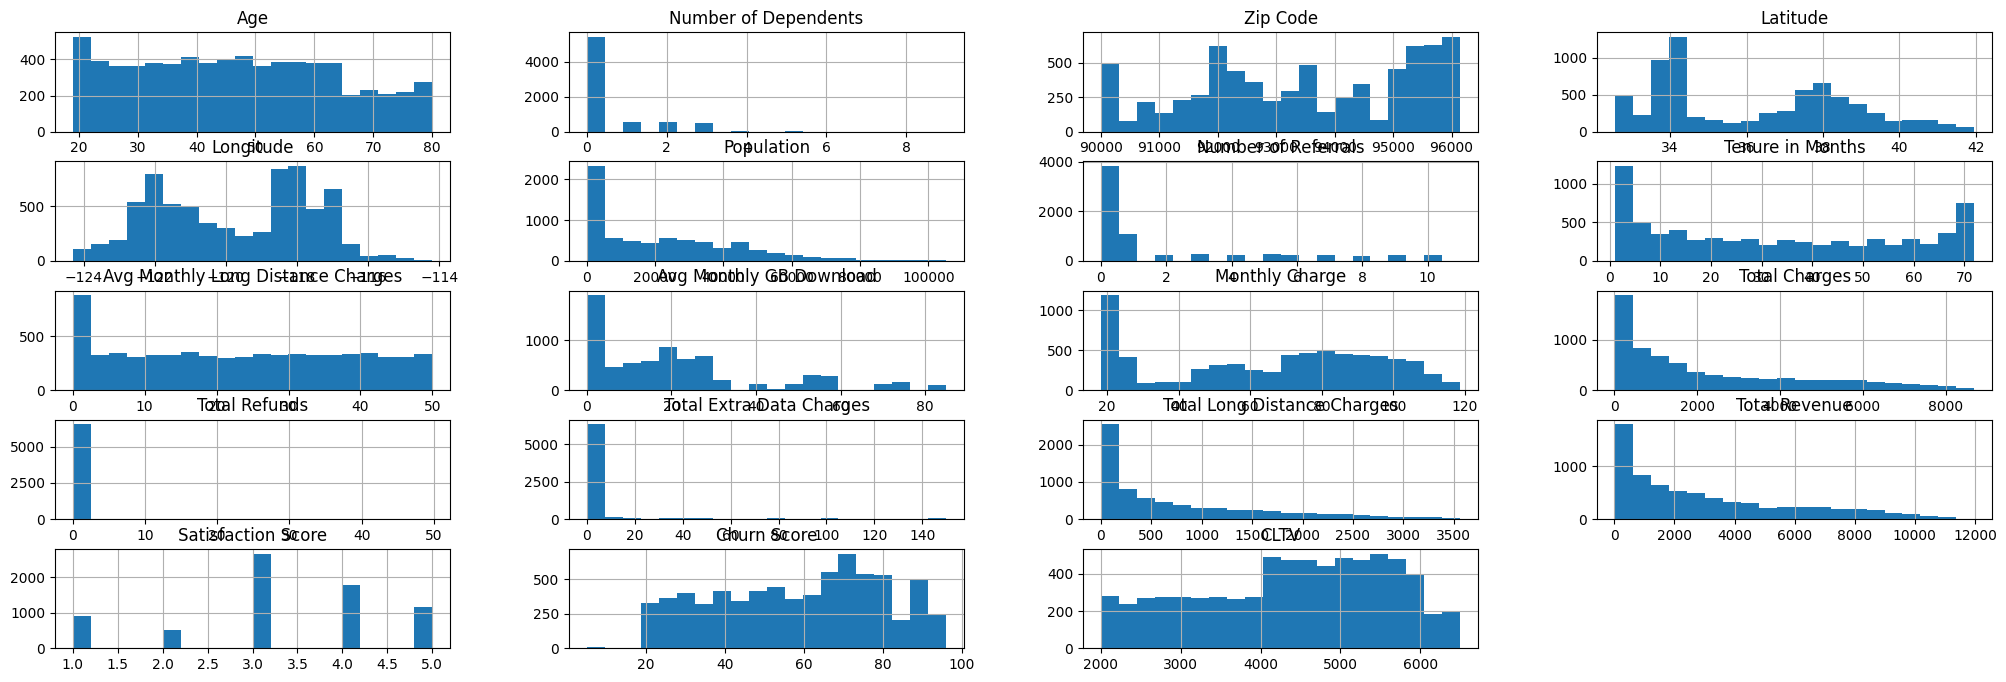

In [6]:
data.hist(bins=20, figsize=(25,8))
plt.plot()

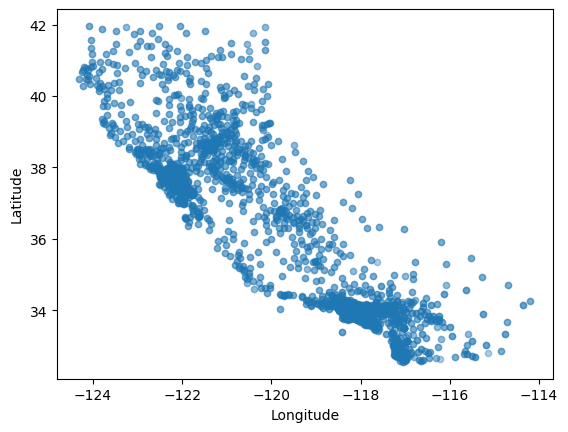

In [7]:
# let us explore the geographical information provided
data.plot(kind='scatter', x='Longitude', y='Latitude', grid=False, alpha=0.2)
plt.show()

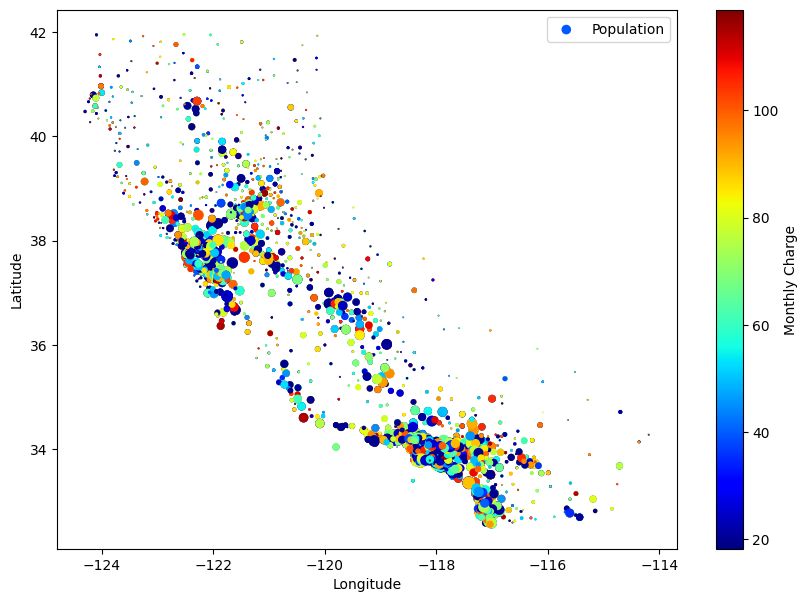

In [8]:
# let us explore the geographical information provided with respect to population and the Monthly Charge
data.plot(kind='scatter', x='Longitude', y='Latitude', grid=False, s=data['Population']/1500, label='Population',
          c='Monthly Charge', cmap='jet', colorbar=True, legend=True, sharex=False, figsize=(10,7))
plt.show()

larger circles indicate areas with a large population, red points tell us that the area has a high charges

**clean the data**

In [9]:
def dataFrame_summary(df):
    """
    Generates a summary of the DataFrame, including data types,
    missing values, unique values, and descriptive statistics.

    Parameters:
    df (pandas.DataFrame): The DataFrame to summarize.

    Returns:
    pandas.DataFrame: A DataFrame containing the following columns:
        - 'data type': The data type of the column.
        - '#missing': The number of missing values in the column.
        - '%missing': The percentage of missing values in the column.
        - '#unique': The number of unique values in the column.
        - 'min': The minimum value in the column (if applicable).
        - 'max': The maximum value in the column (if applicable).
        - 'average': The mean of the column (if applicable).
        - 'standard_deviation': The standard deviation of the column.
        - 'first value': The first value in the column.
        - 'second value': The second value in the column.
        - 'third value': The third value in the column.
    """
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    return summ

In [10]:
#let us separate the data so that we don't look into test set
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Churn Label'], axis=1), data['Churn Label'], test_size=0.2, shuffle=True,  stratify=data['Churn Label'], random_state=42)

In [11]:
print('Training Set: ', X_train.shape)
print('Test Set: ', X_test.shape)
print('----------')
print('Training label: ', y_train.shape)
print('Test label: ', y_test.shape)

Training Set:  (5634, 49)
Test Set:  (1409, 49)
----------
Training label:  (5634,)
Test label:  (1409,)


In [12]:
dataFrame_summary(X_train).style.background_gradient(cmap='YlOrBr')

data shape: (5634, 49)


In [13]:
# we see that we have some missing values, we have some categorical column with just one value
# let us not run a bivariate analysis of the categorical column with respect to the target variable

def bivariante_analysis_cat(df, column_list, label, graph_label):
    '''
    Generate graphs comparing categorical features with a categorical label

    Parameters:
    df (pandas.DataFrame): The DataFrame
    column_list (list)   : The list with all the categorical features to consider
    label (str)          : The label used to see the distribution
    graph_label (str)    : the label of the x axis
    '''
    for column in column_list:
        plt.figure(figsize=(30,4))
        plt.subplot(121)
        ax = sns.countplot(df, x=column, hue=df[label].astype(str))
        for i in ax.containers:
            ax.bar_label(i,)
        plt.ylabel(graph_label)
        plt.xticks(rotation=90)

In [14]:
# we have categorical and numerical features, so let us separate them into two variables
features_cat = list(X_train.select_dtypes(exclude = ['int64','float64']))
features_num = list(X_train.select_dtypes(include = ['int64','float64']))

# it is important to view the cardinality of the categorical data
X_train[features_cat].nunique().sort_values(ascending=False)

Customer ID               5634
City                      1104
Churn Reason                20
Churn Category               5
Offer                        5
Internet Type                3
Customer Status              3
Payment Method               3
Contract                     3
Online Backup                2
Paperless Billing            2
Unlimited Data               2
Streaming Music              2
Streaming Movies             2
Streaming TV                 2
Premium Tech Support         2
Device Protection Plan       2
Senior Citizen               2
Married                      2
Gender                       2
Internet Service             2
Multiple Lines               2
Phone Service                2
Referred a Friend            2
Under 30                     2
Dependents                   2
Online Security              2
Quarter                      1
State                        1
Country                      1
dtype: int64

In [15]:
# delete all the columns with just one (1) unique value - because all the columns have the same information
X_train.drop(['Country','State','Quarter'], axis=1, inplace=True)
X_test.drop(['Country','State','Quarter'], axis=1, inplace=True)

# we can delete columns with a very high cardinality (we can keep the customer id)
# for in case we want to get more information about the customer
X_train.drop(['City'], axis=1, inplace=True)
X_test.drop(['City'], axis=1, inplace=True)

In [16]:
# deleting the customer id from the list of categorical features
features_cat.remove('Customer ID')
features_cat.remove('Country')
features_cat.remove('State')
features_cat.remove('Quarter')
features_cat.remove('City')

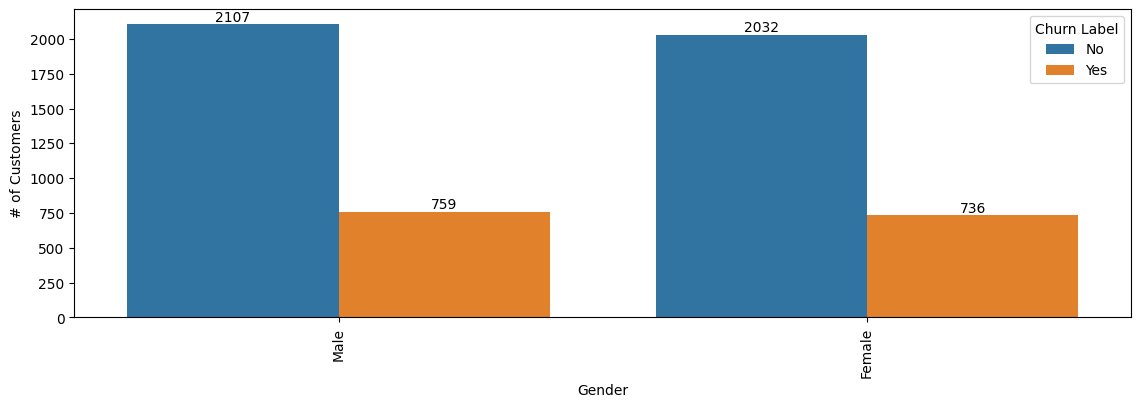

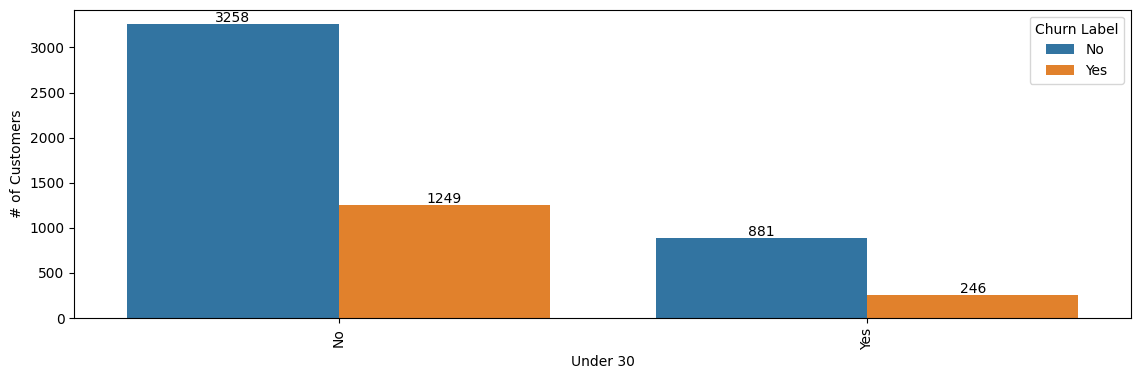

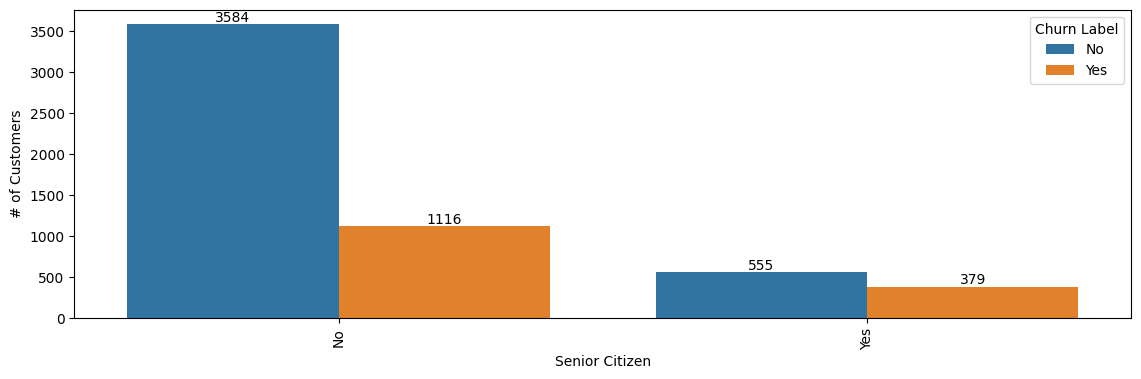

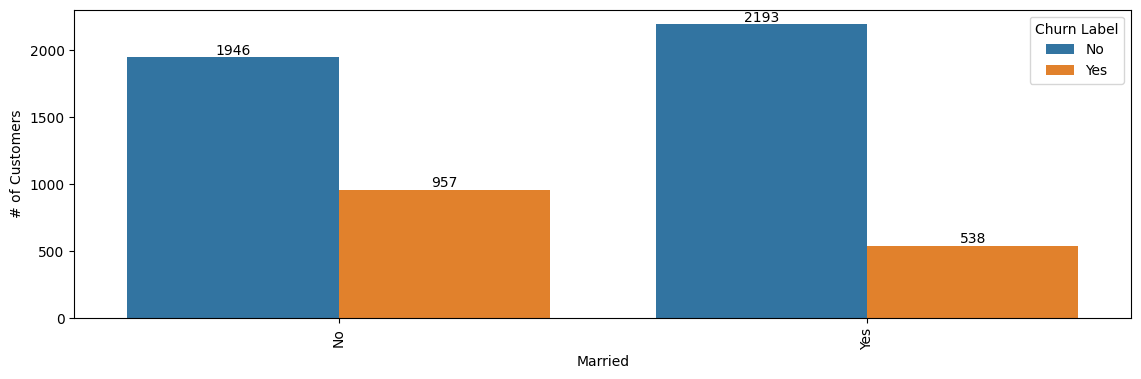

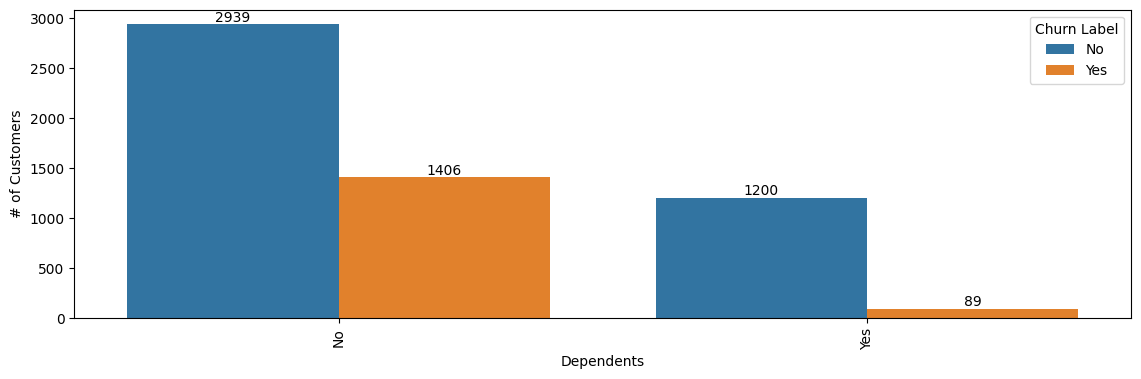

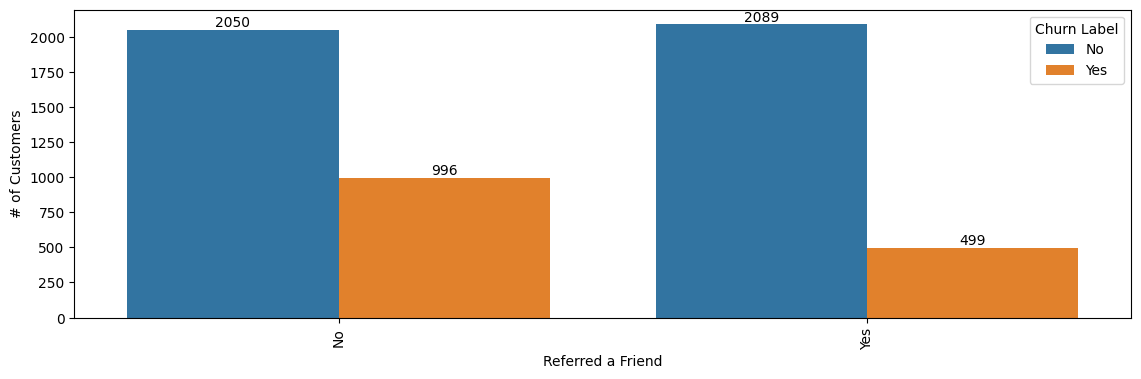

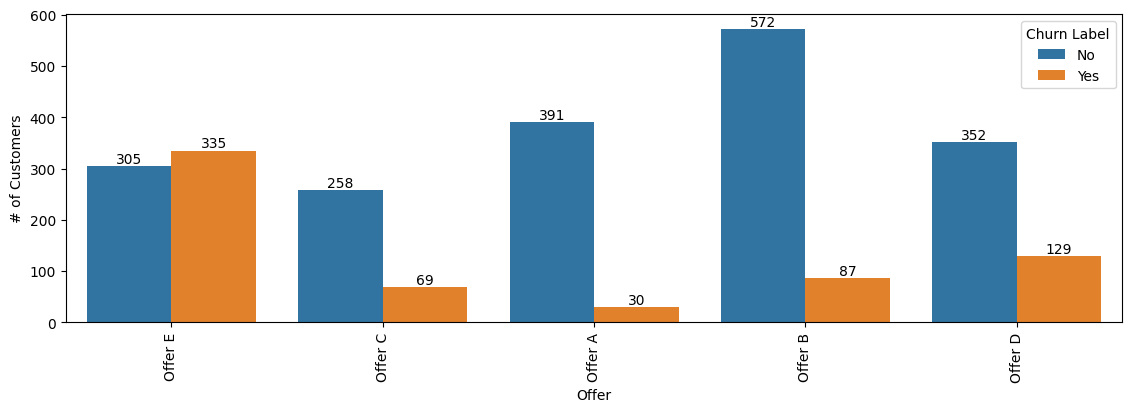

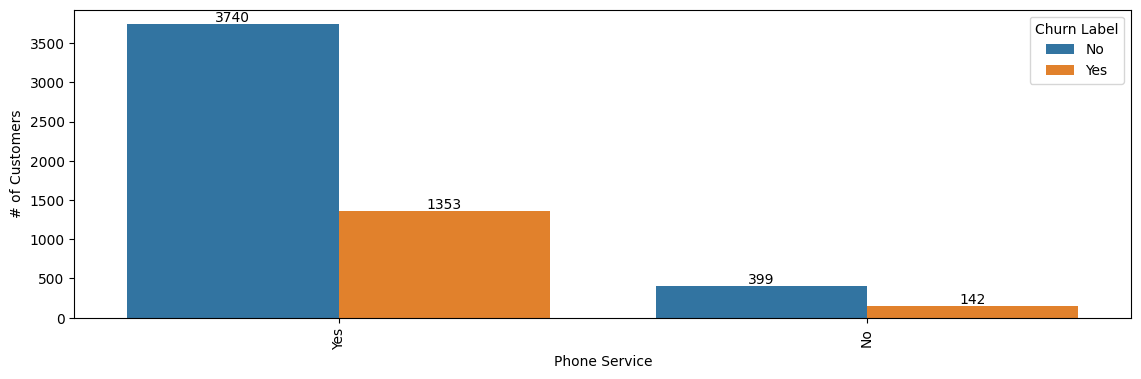

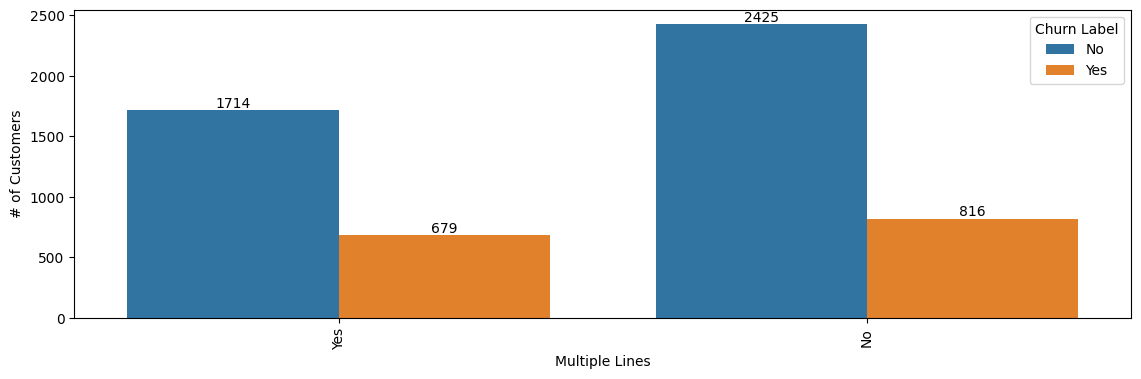

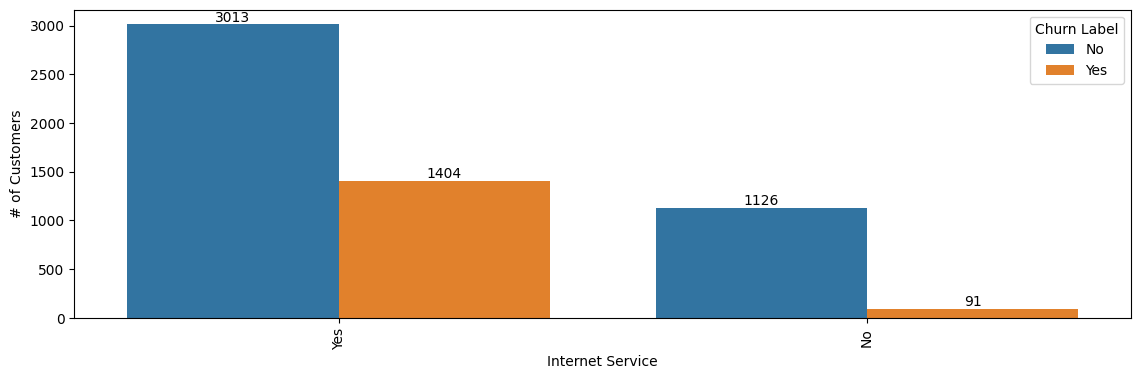

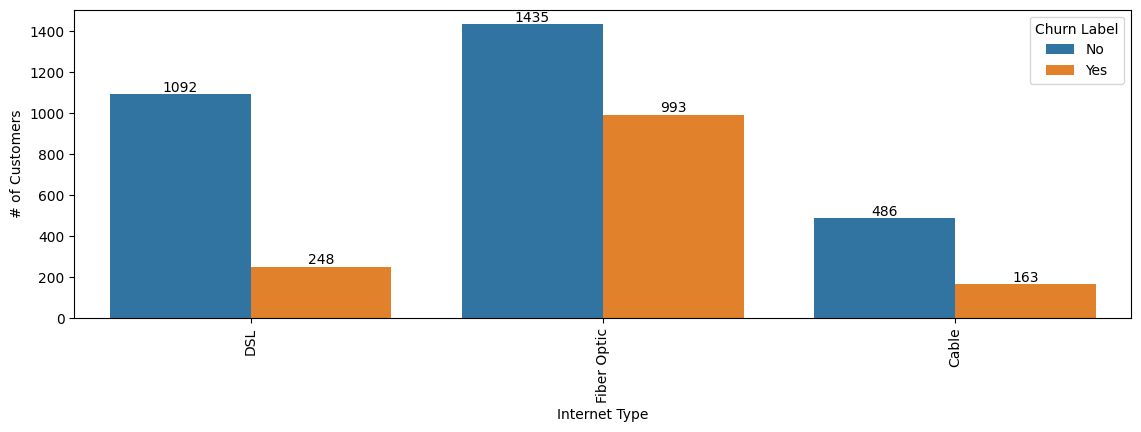

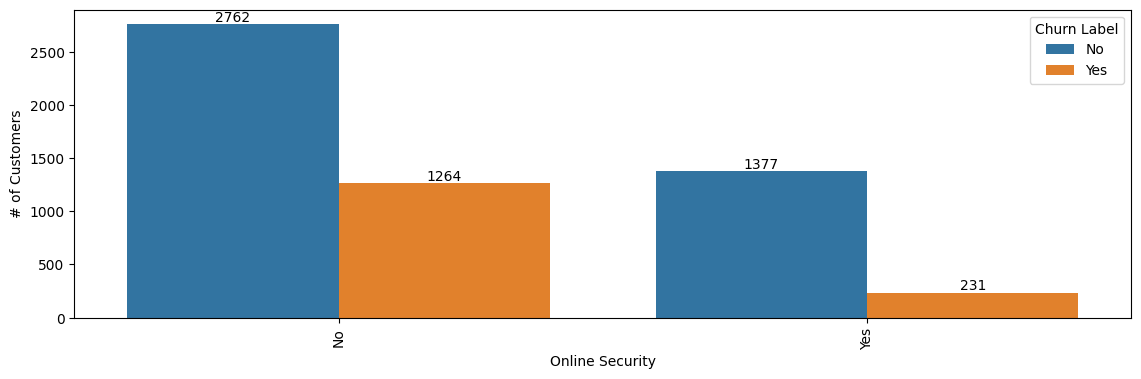

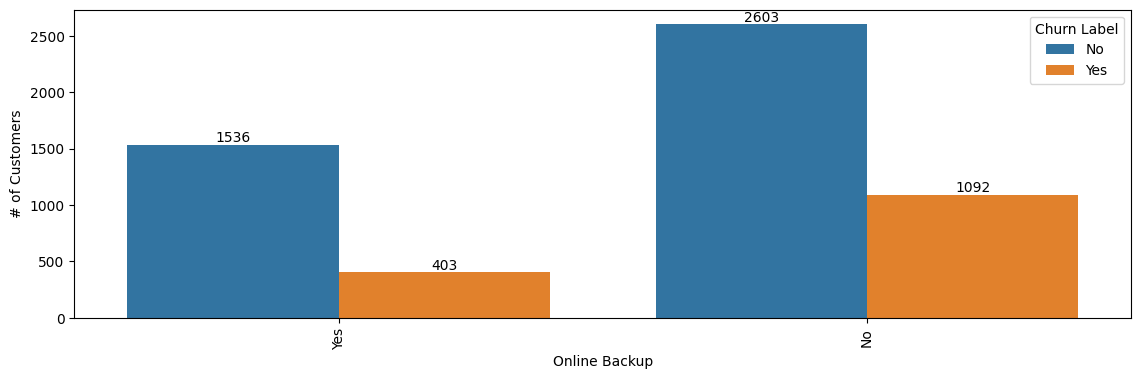

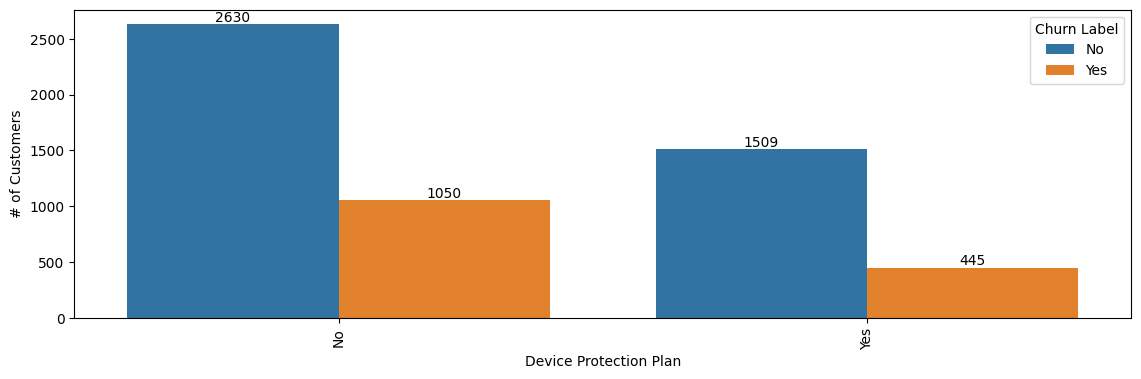

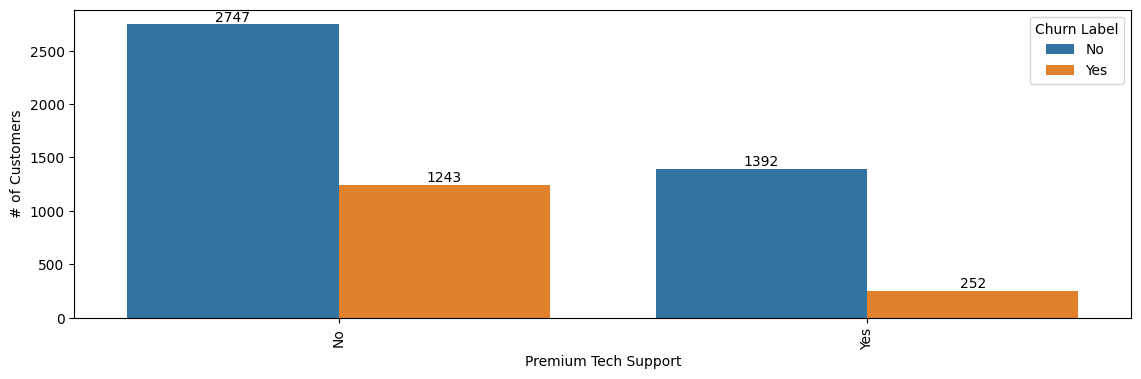

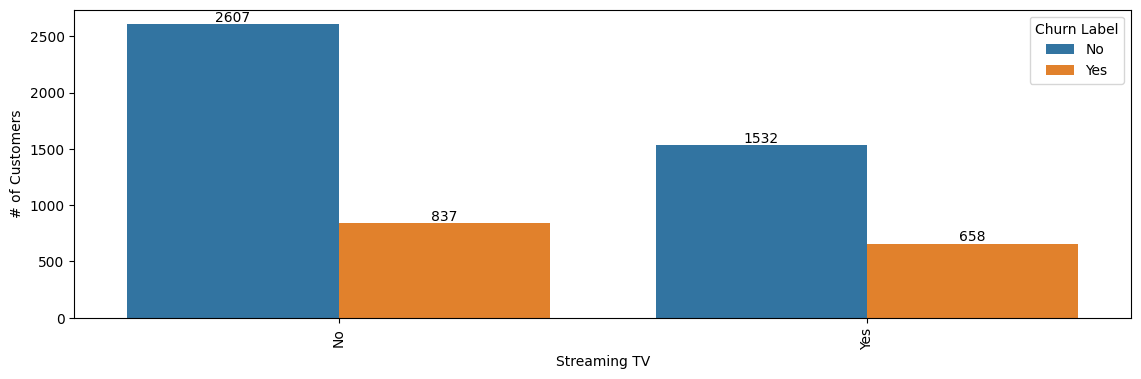

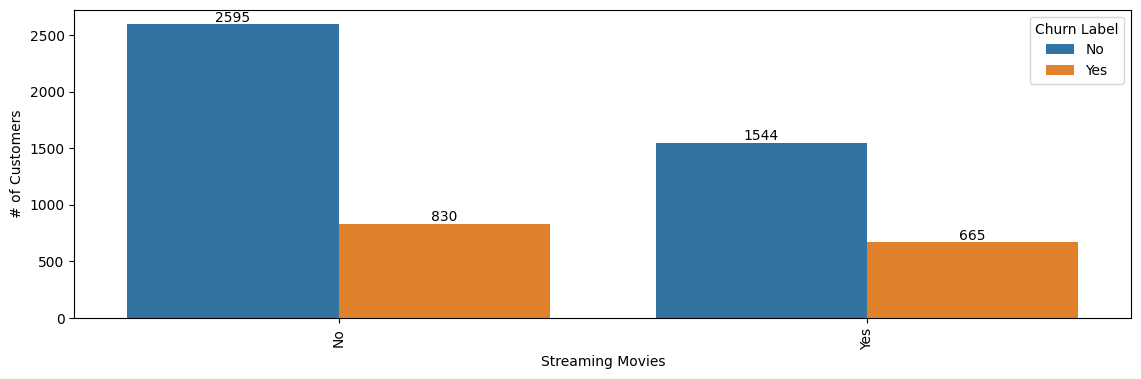

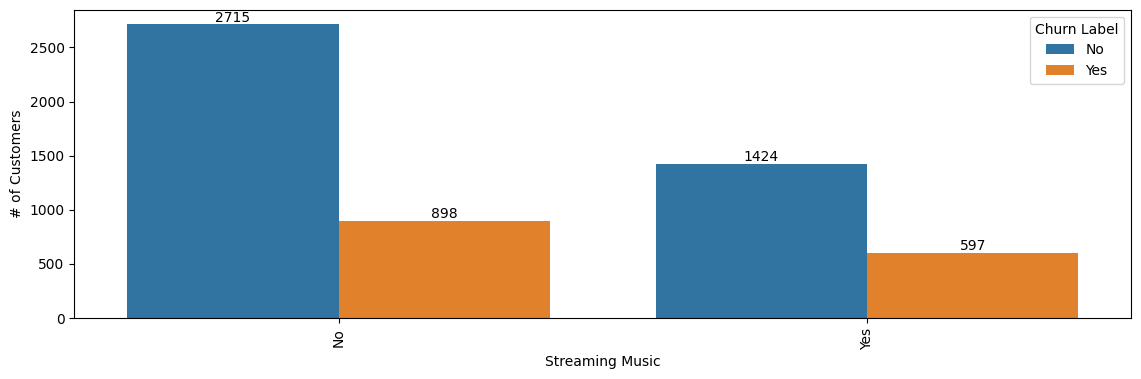

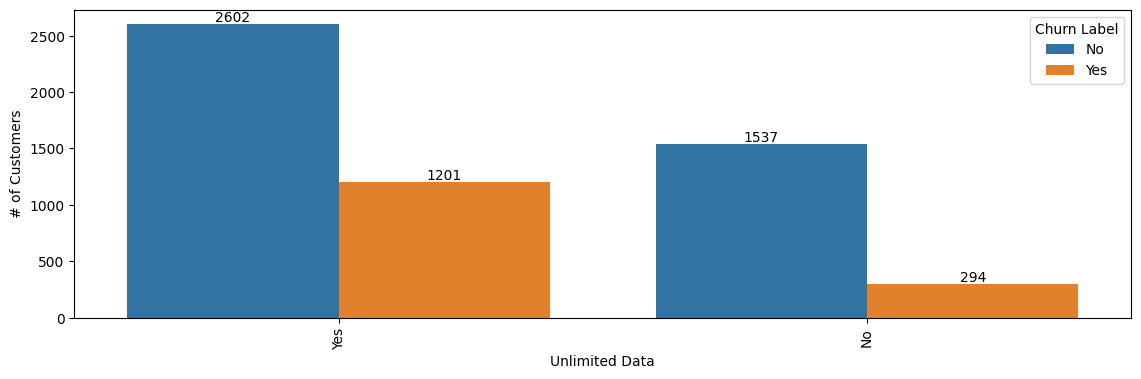

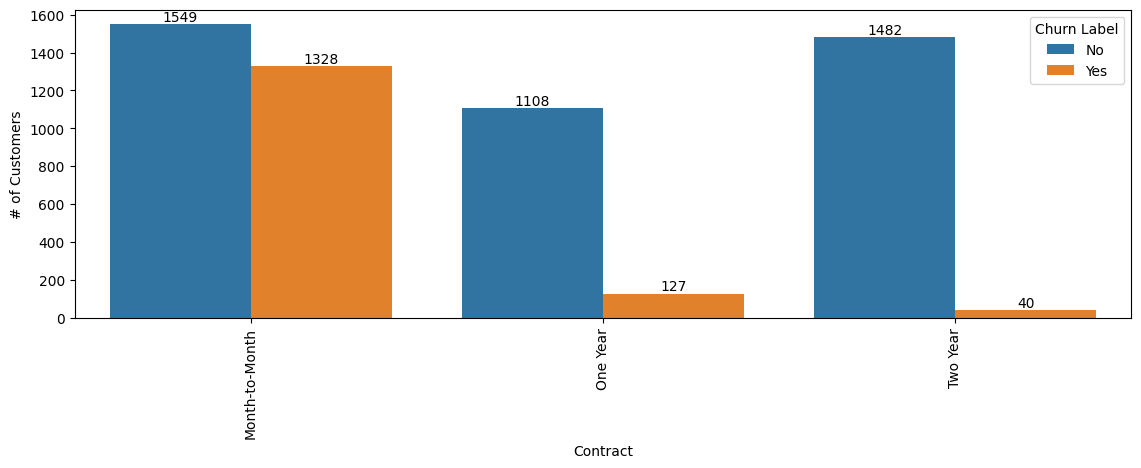

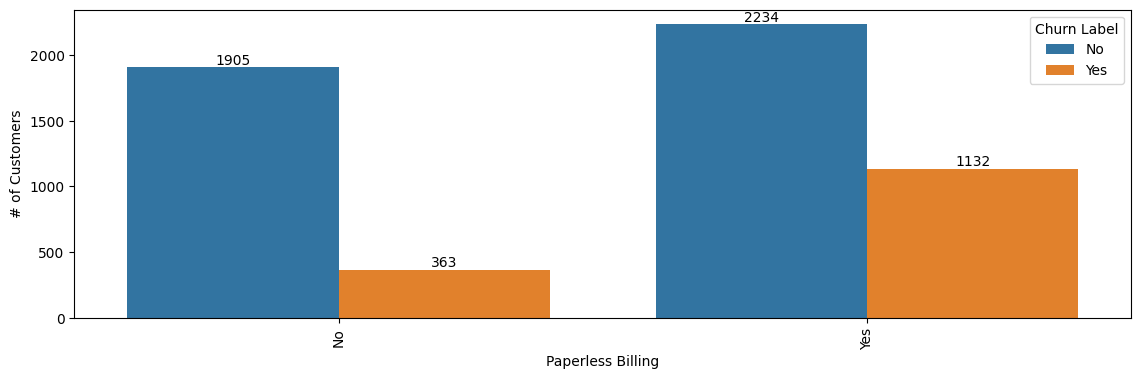

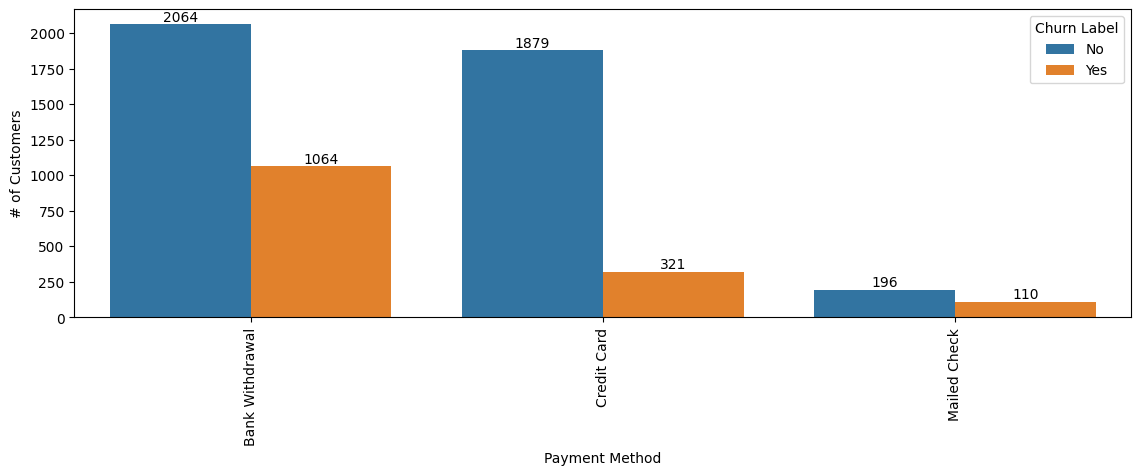

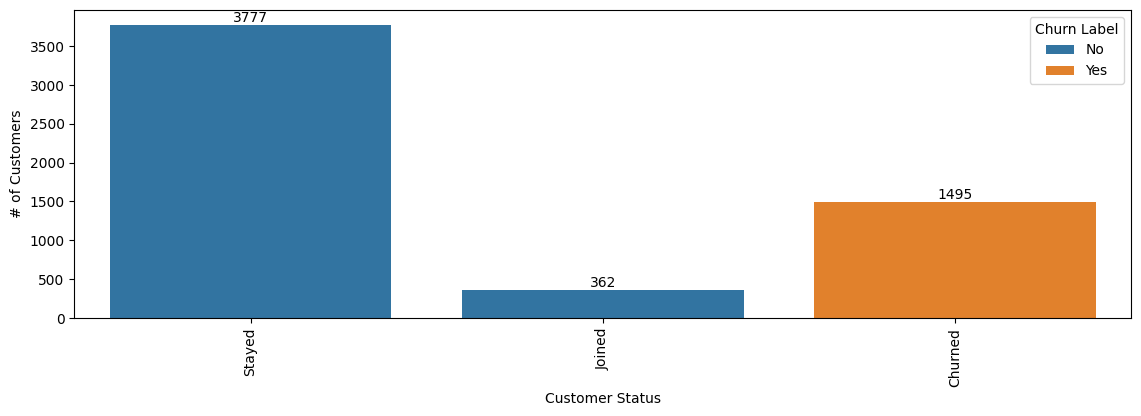

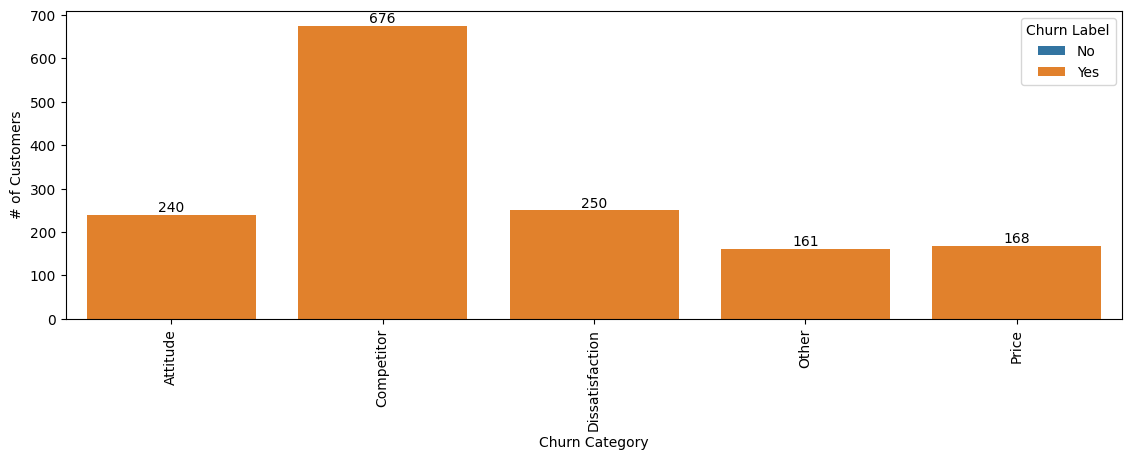

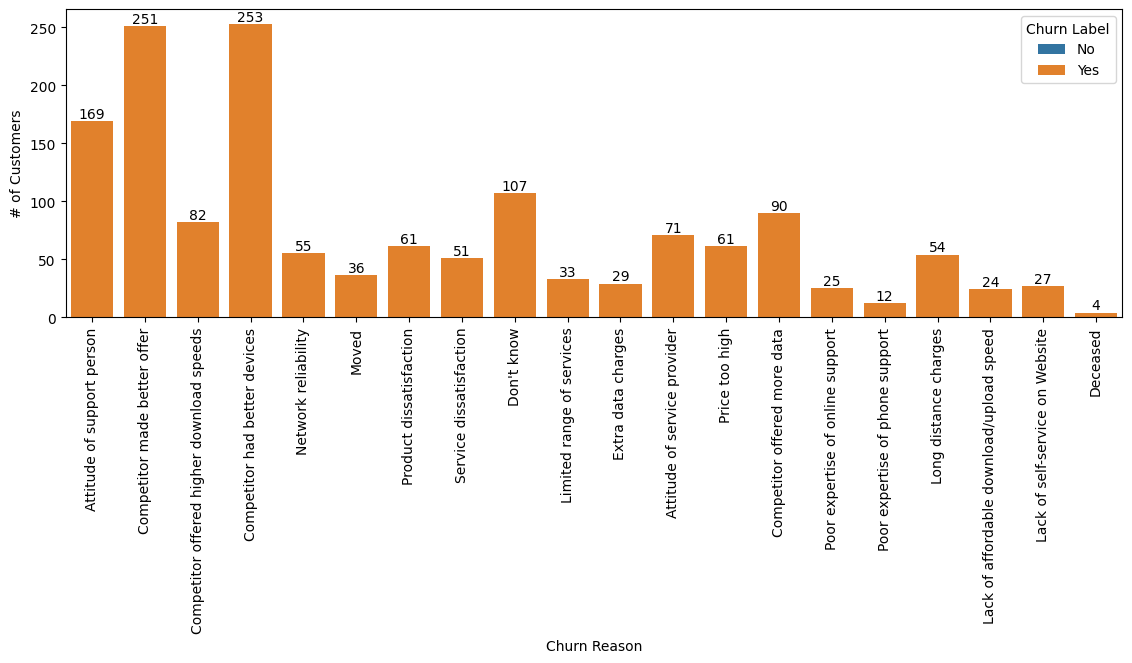

In [17]:
# to be able to see the target in respect to other categorical features,
# we need to concat the label and the variables

bivariante_analysis_cat(pd.concat([X_train, y_train], axis=1),
                        features_cat, 'Churn Label', '# of Customers')

In [18]:
# from the bivariate analysis, we can see that some
# columns leak information about the target
# of the target,so we need to be carefull about them
# for this exercise we are going to drop the columns

X_train.drop(['Customer Status', 'Churn Category', 'Churn Reason'],
             axis=1, inplace=True)
X_test.drop(['Customer Status', 'Churn Category', 'Churn Reason'],
            axis=1, inplace=True)

In [19]:
# we now need to remove all the columns that we just dropped
features_cat.remove('Customer Status')
features_cat.remove('Churn Category')
features_cat.remove('Churn Reason')


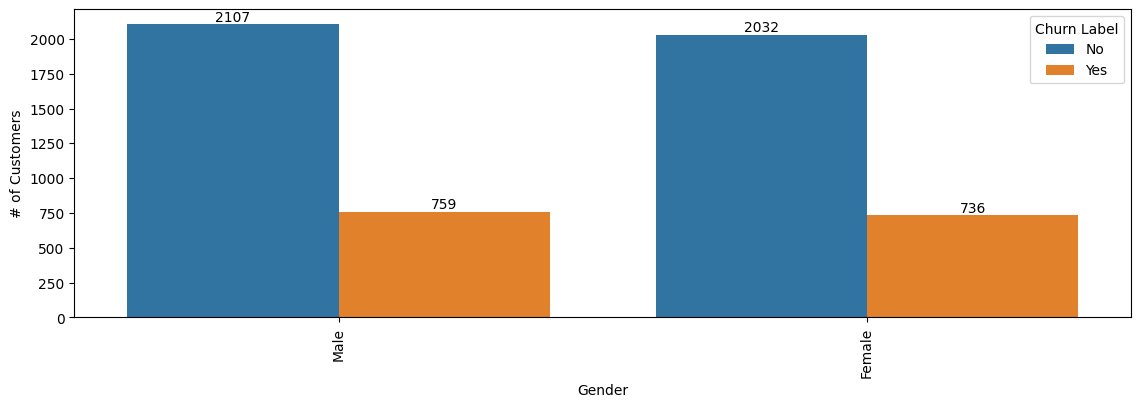

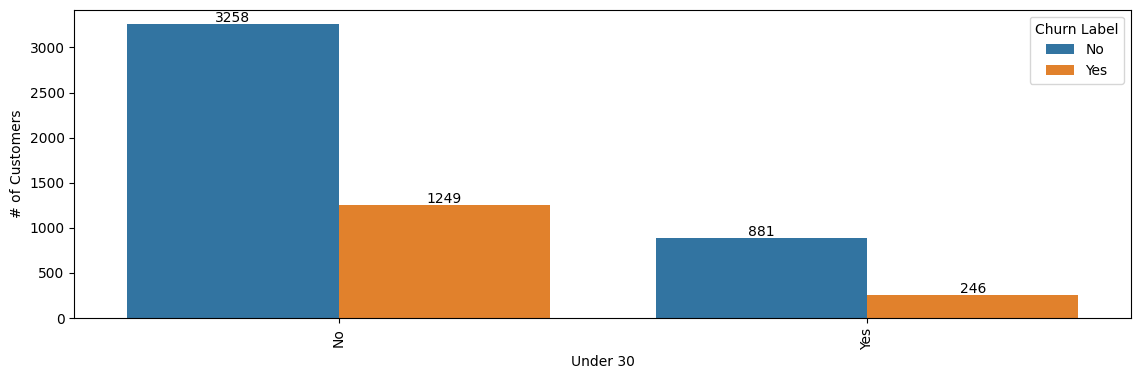

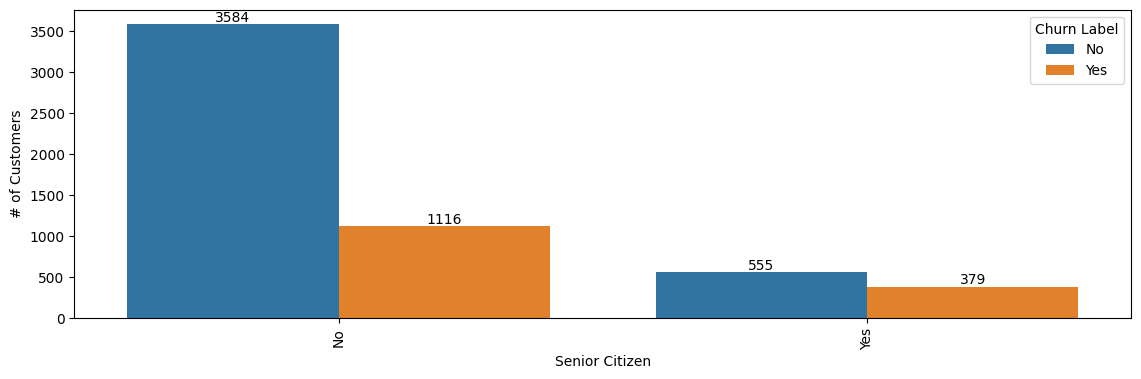

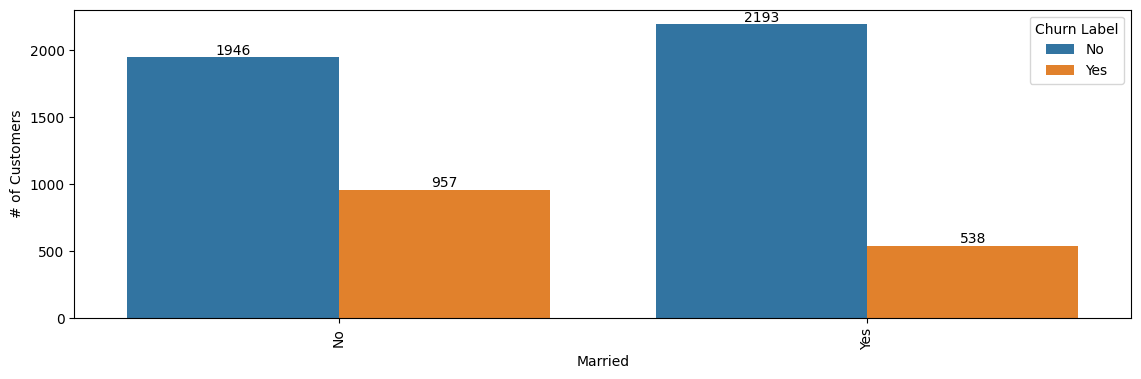

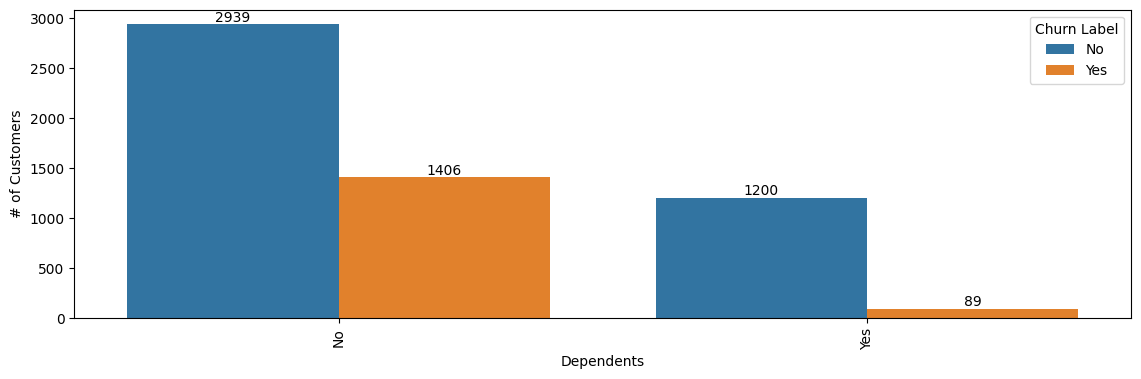

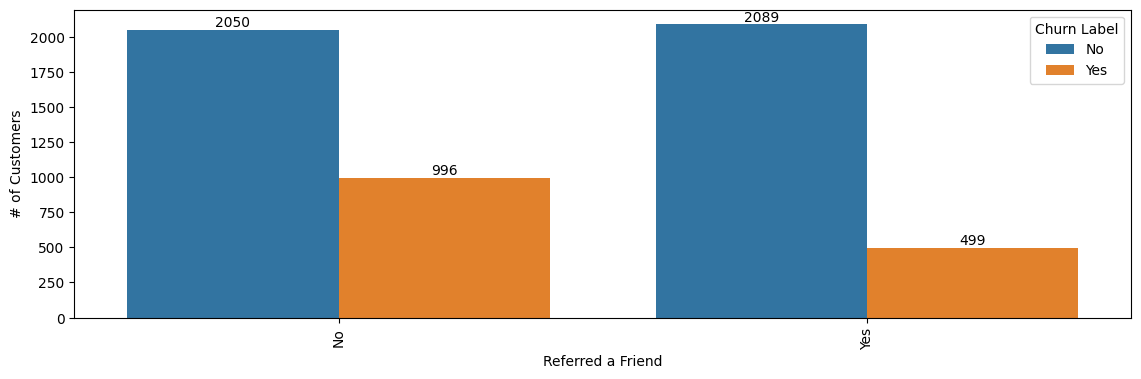

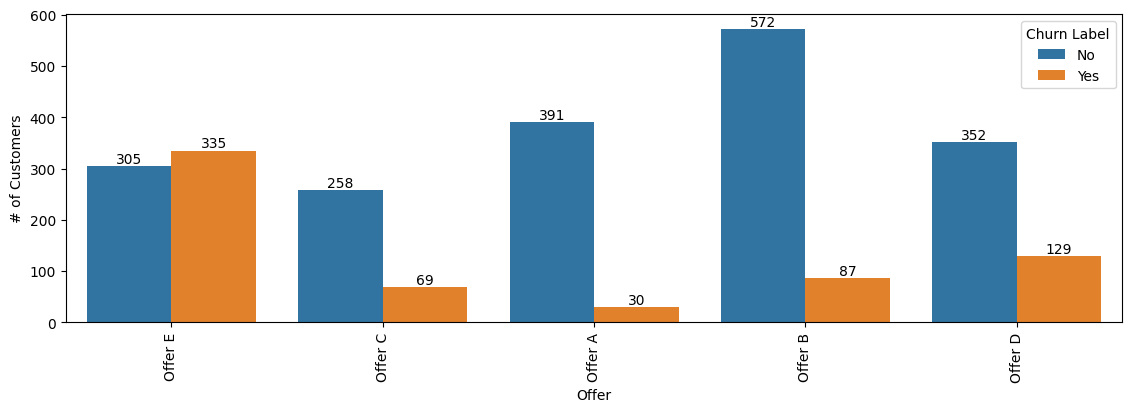

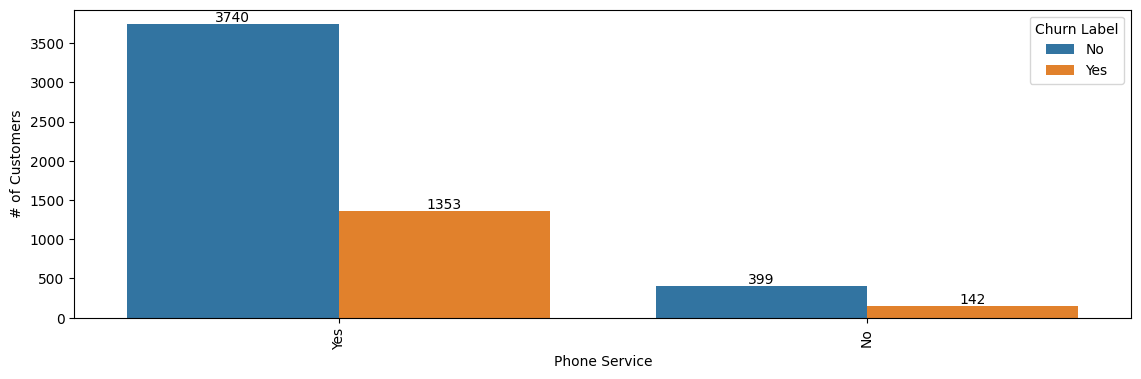

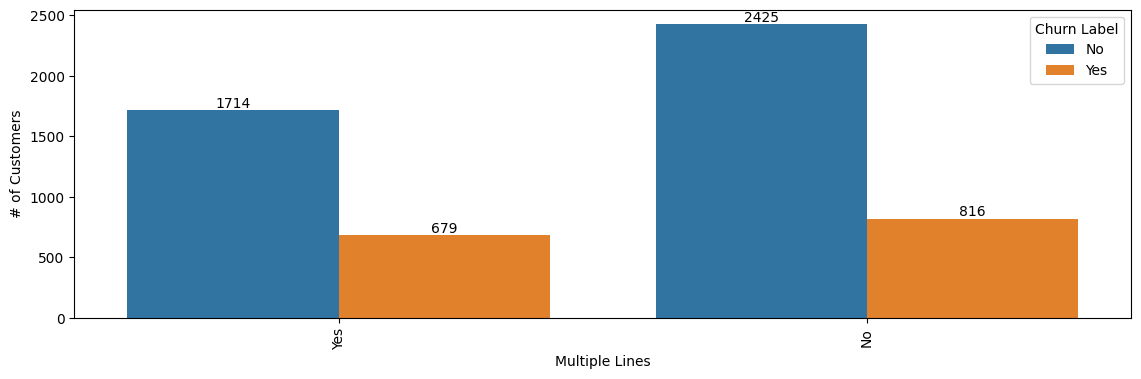

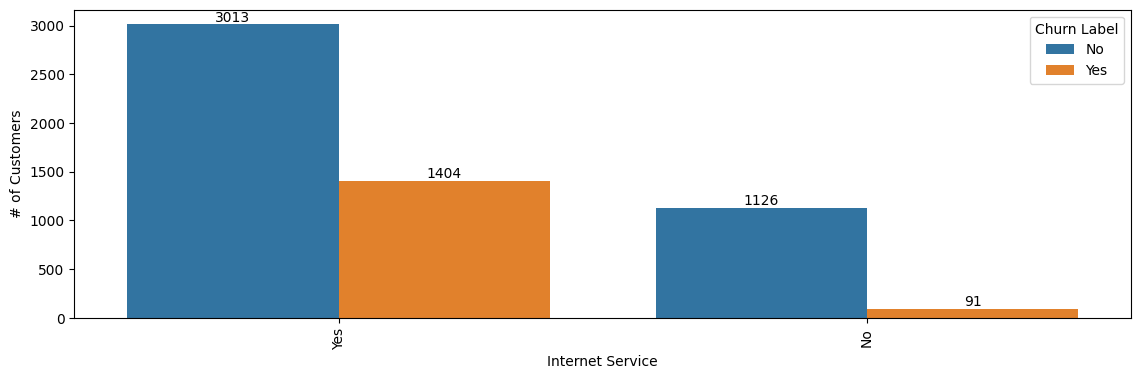

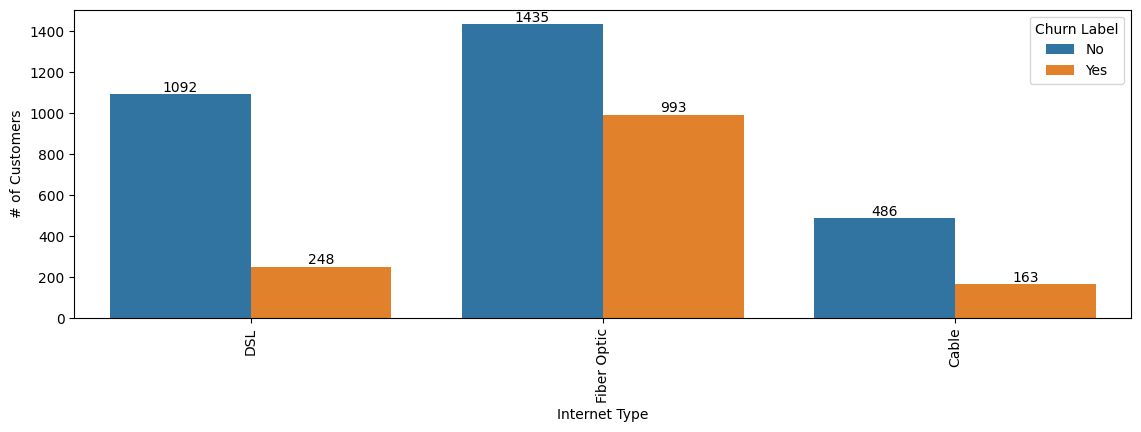

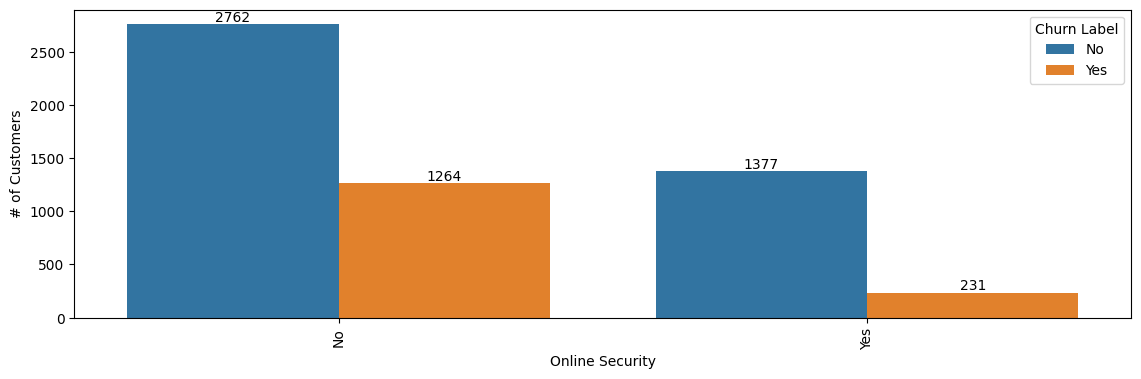

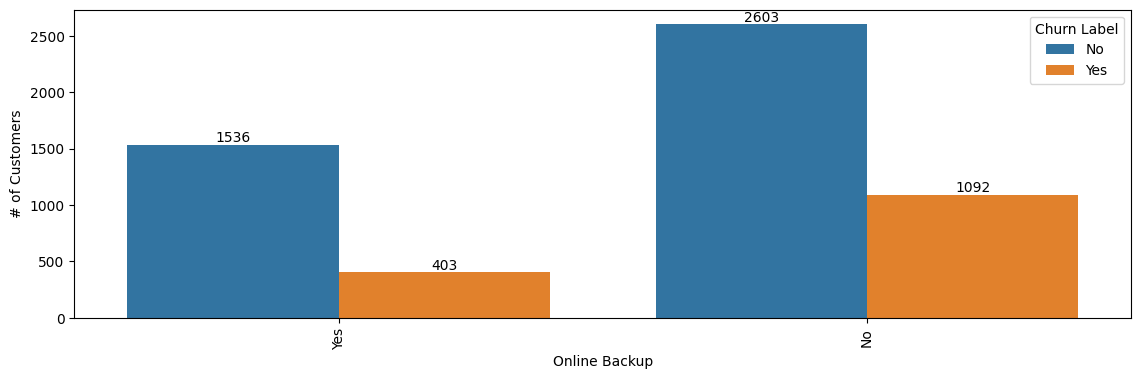

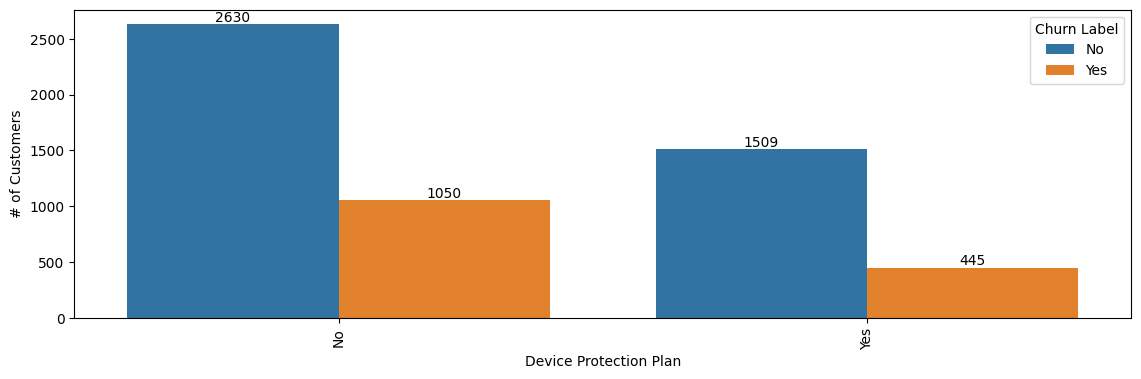

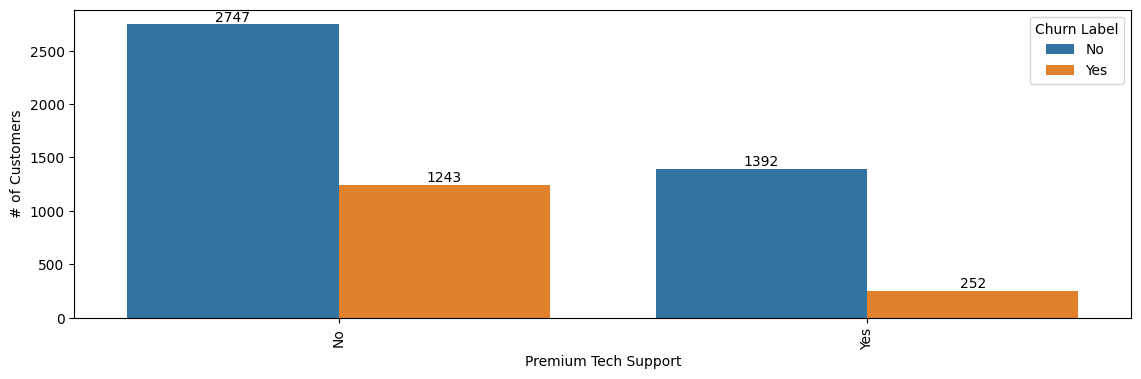

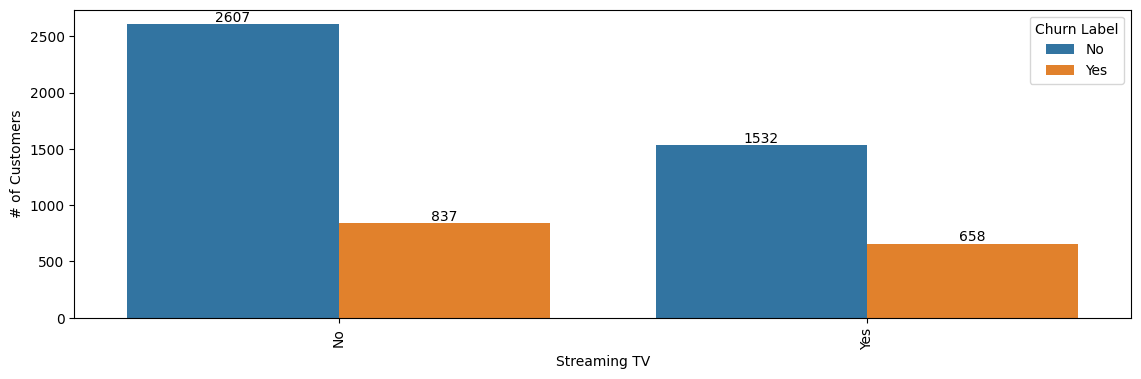

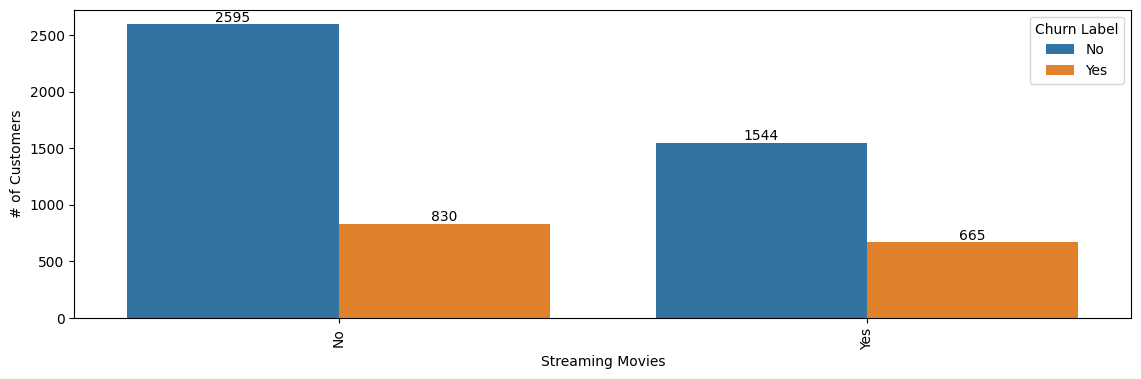

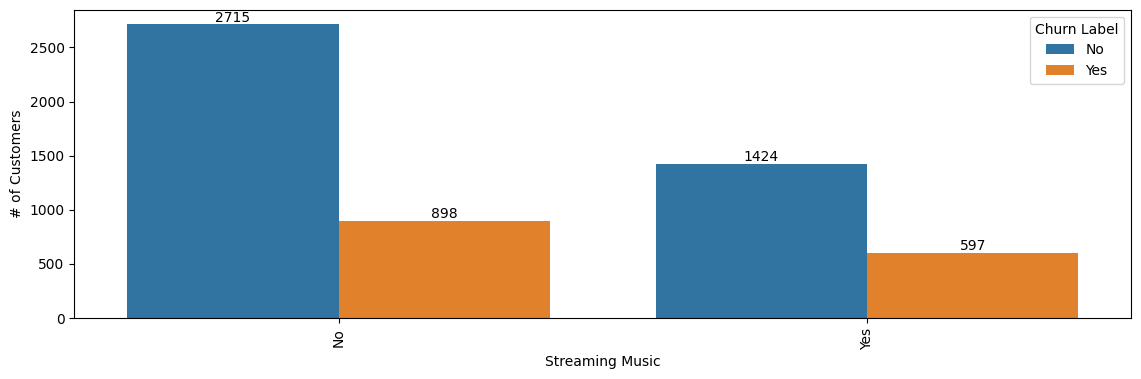

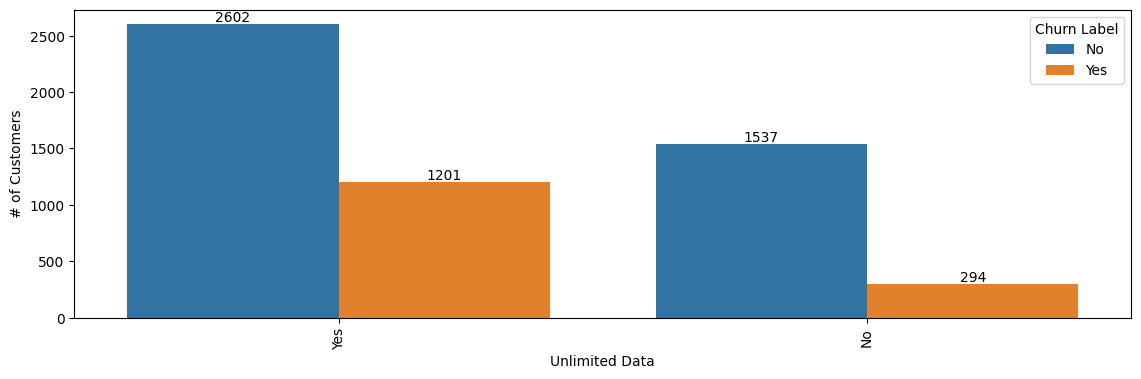

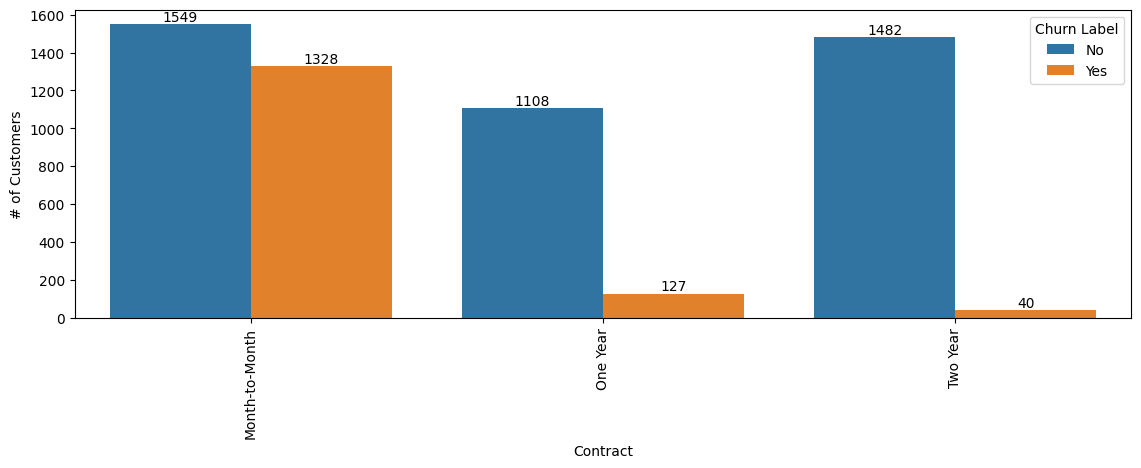

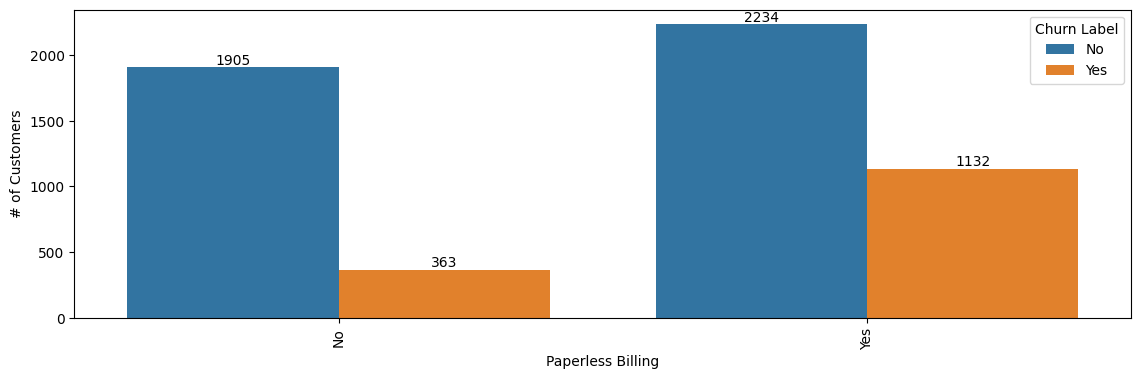

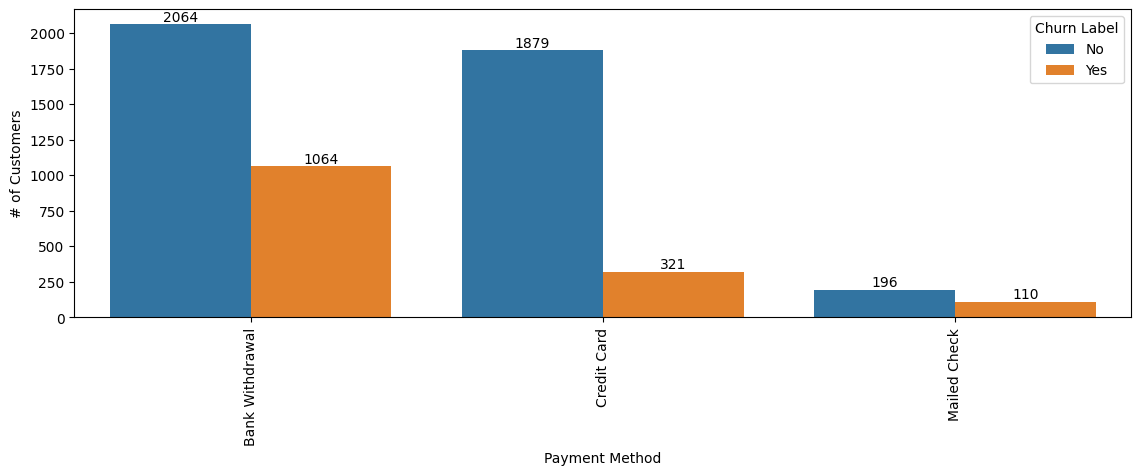

In [20]:
bivariante_analysis_cat(pd.concat([X_train,y_train], axis=1), features_cat, 'Churn Label', '# of Customers')

Now our categorical data make more sense

let us now do the same analysis but this time ooking at the distribution of numerical values
we see that we have some missing values, we have some categorical column with just one value
let us not run a bivariate analysis of the categorical column with respect to the target variable

In [21]:
def bivariante_analysis_num(df, column_list, label, graph_label):
    '''
    Generate graphs with the distribution of numerical values
    with respect to the label

    Parameters:
    df (pandas.DataFrame): The DataFrame
    column_list (list)   : The list with all the numerical features
    label (str)          : The label used to see the distribution
    graph_label (str)    : the label of the x axis
    '''
    for column in column_list:
        plt.figure(figsize=(20, 4))
        plt.subplot(121)
        sns.histplot(x=column, hue=df['Churn Label'],
                     data=df, bins=30, kde=True, palette='YlOrRd')
        plt.title(column)
        plt.ylabel(graph_label)
        plt.xticks(rotation=90)

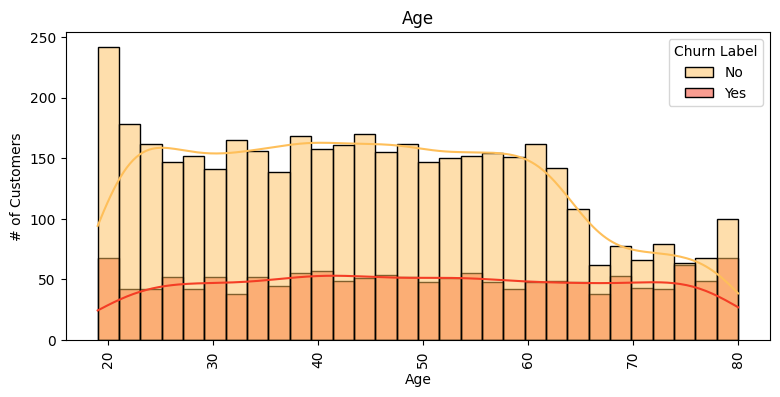

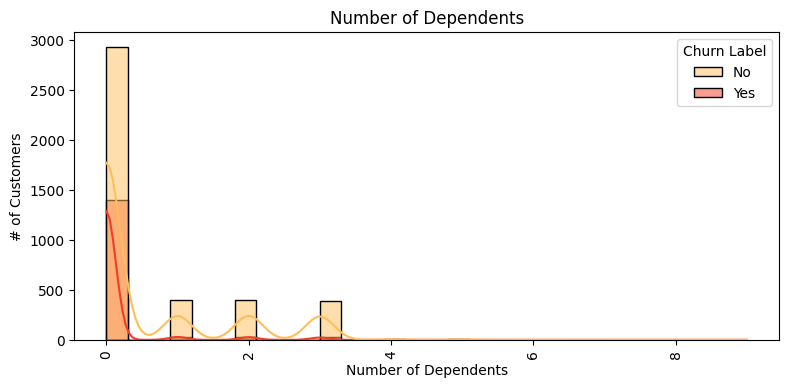

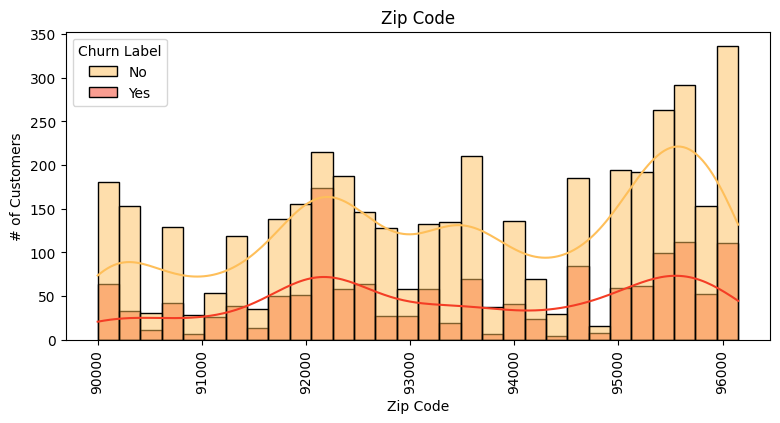

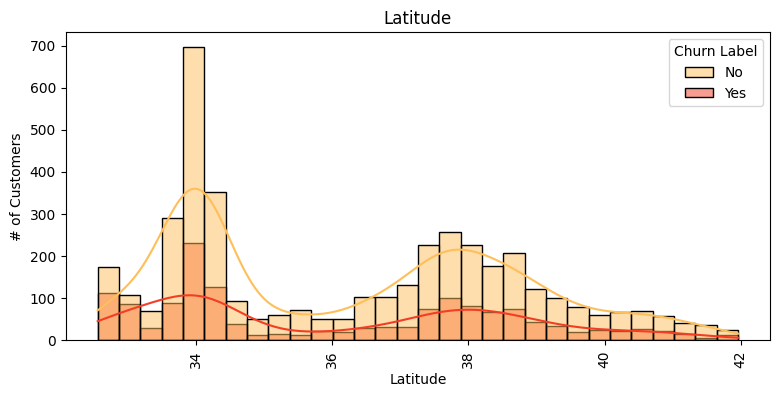

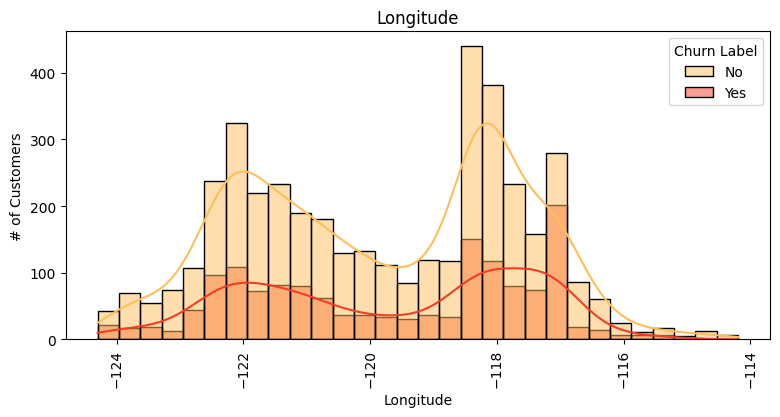

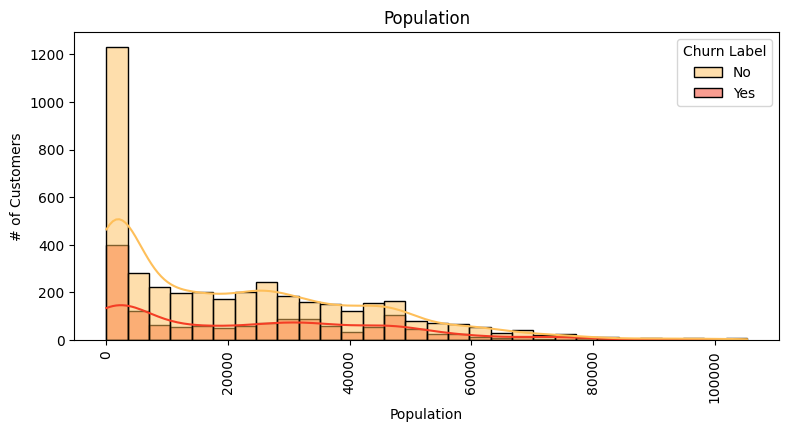

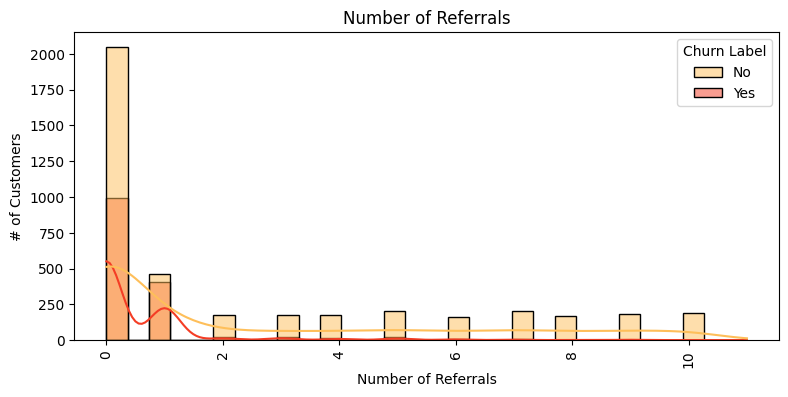

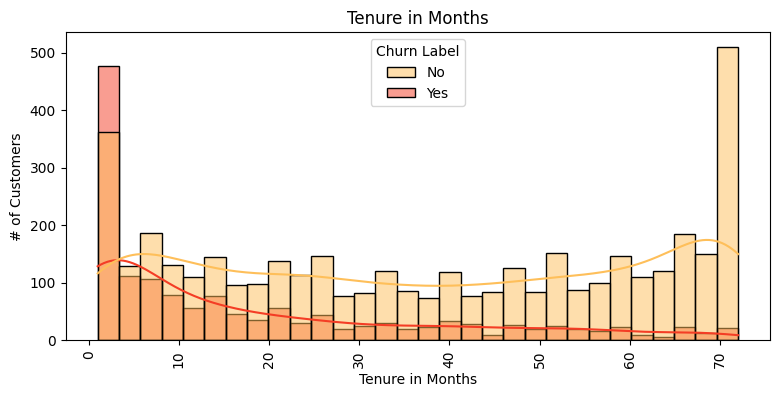

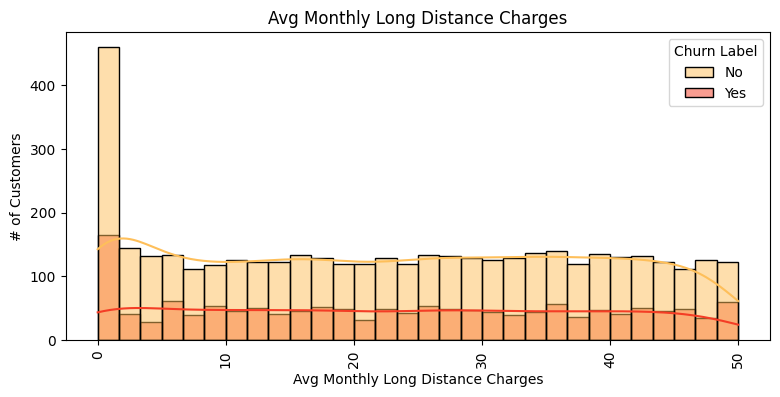

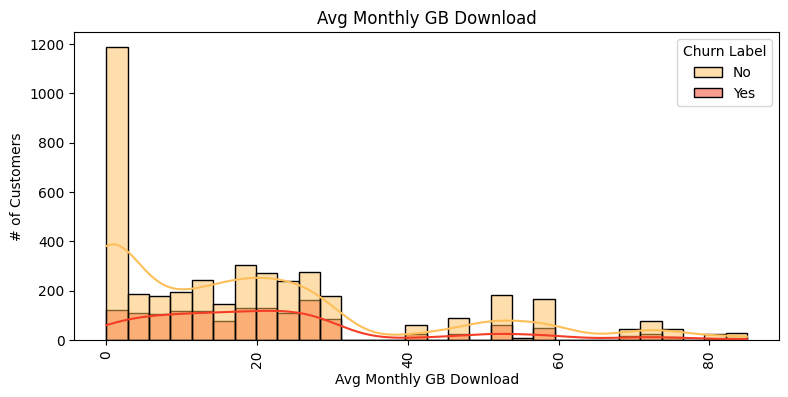

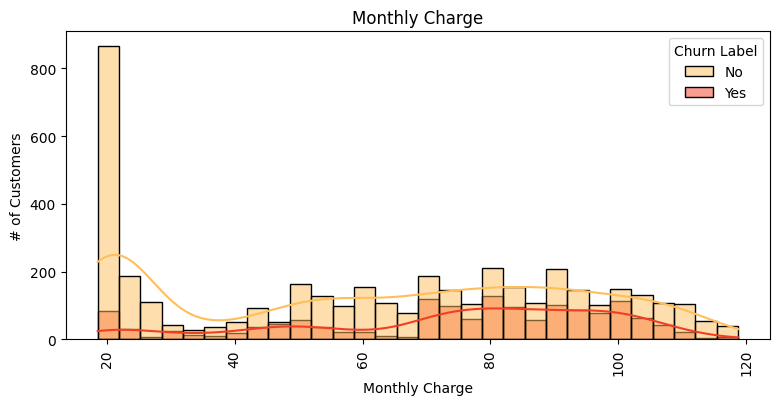

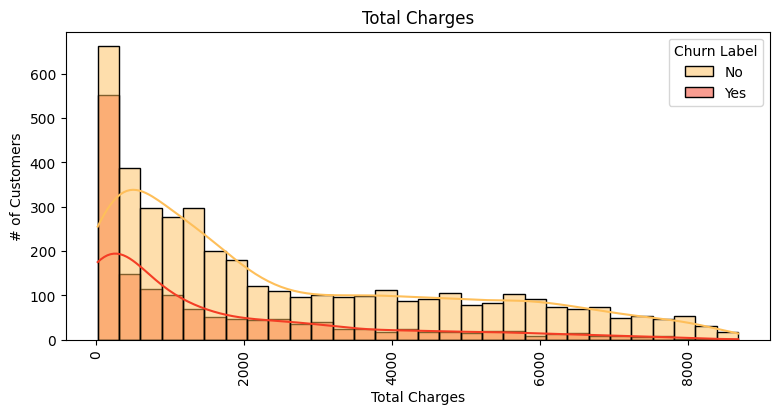

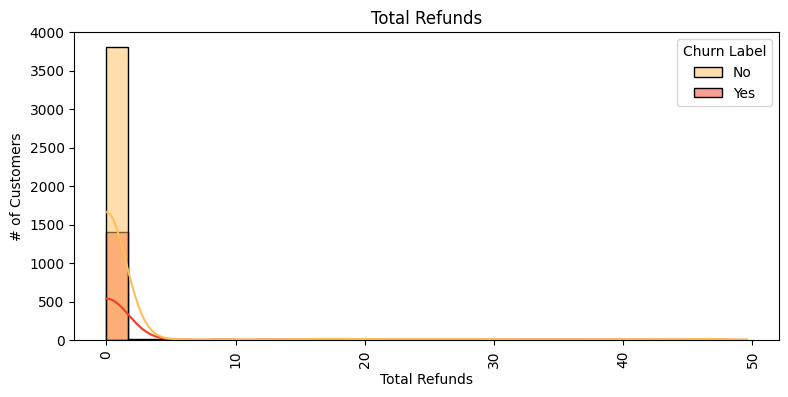

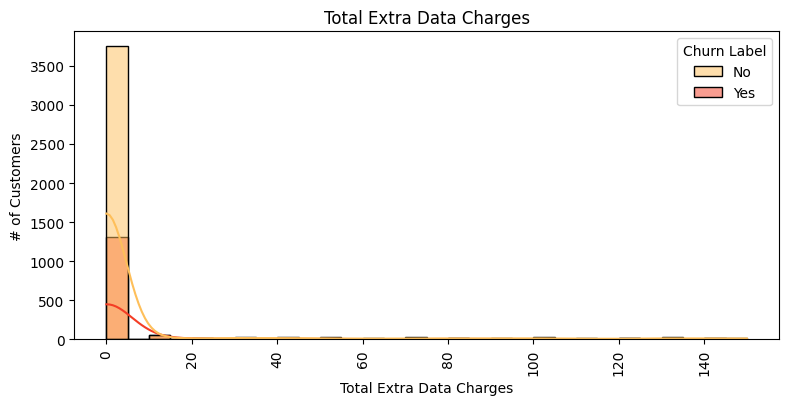

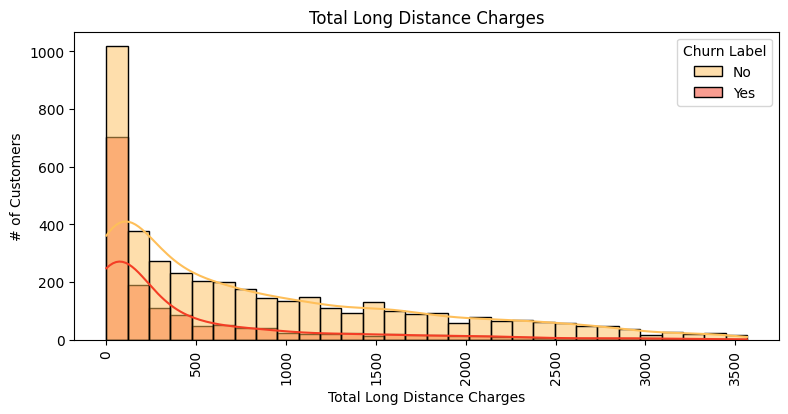

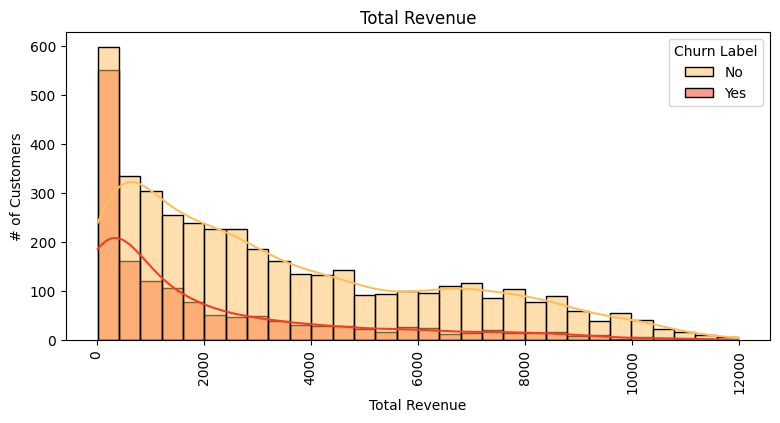

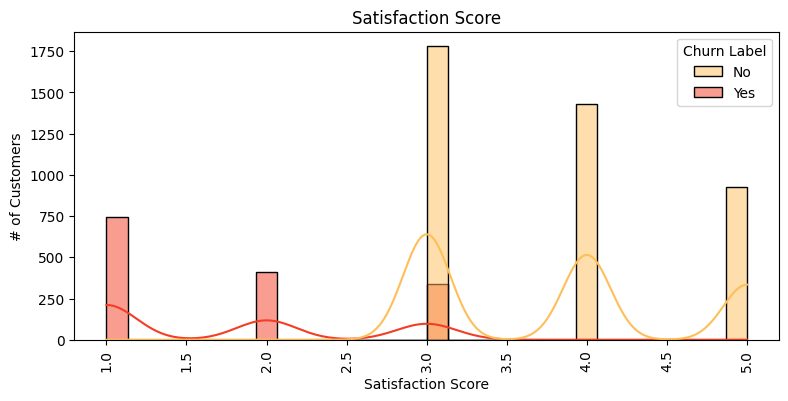

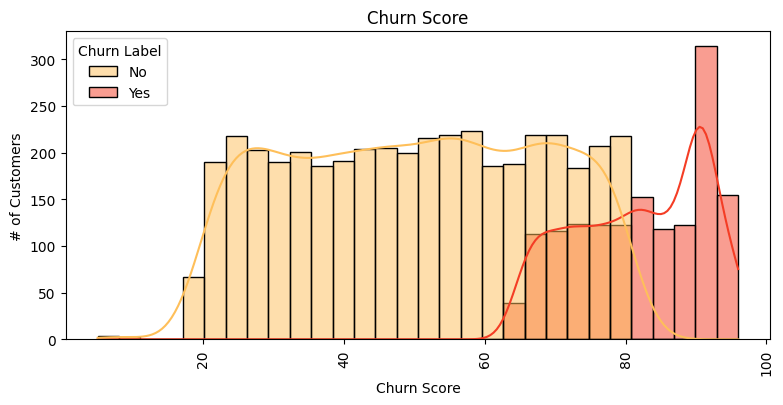

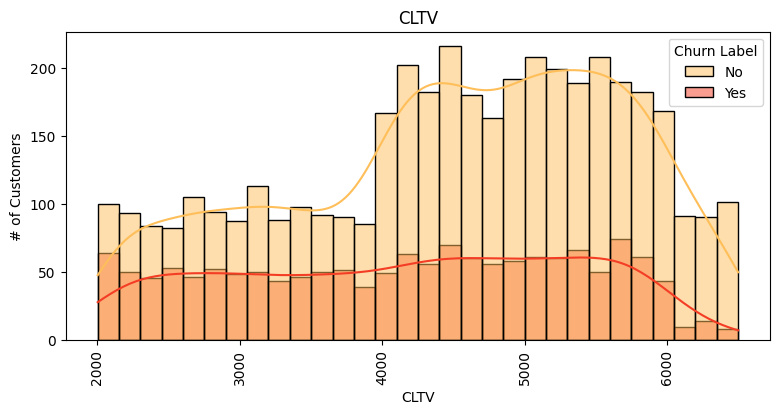

In [22]:
bivariante_analysis_num(pd.concat([X_train, y_train], axis=1),
                        features_num, 'Churn Label', '# of Customers')

**Section 3: Data Preparation**
Here we are going to clean NAN and encode the categorical features

In [23]:
def plot_nans(df):
    '''
    Generate graphs with the distribution of columns with NAN

    Parameters:
    df (pandas.DataFrame): The DataFrame
    '''
    nan_counts = df.isna().sum()
    # calculate the percentage of NaN values per column
    nan_percentage = (nan_counts / len(df)) * 100
    nan_percentage = nan_percentage[nan_percentage > 0]

    # Plotting
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=nan_percentage.index, y=nan_percentage.values)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.xlabel('Columns')
    plt.ylabel('Percentage of NaN Values')
    plt.title('Columns with NAN values')
    plt.show()

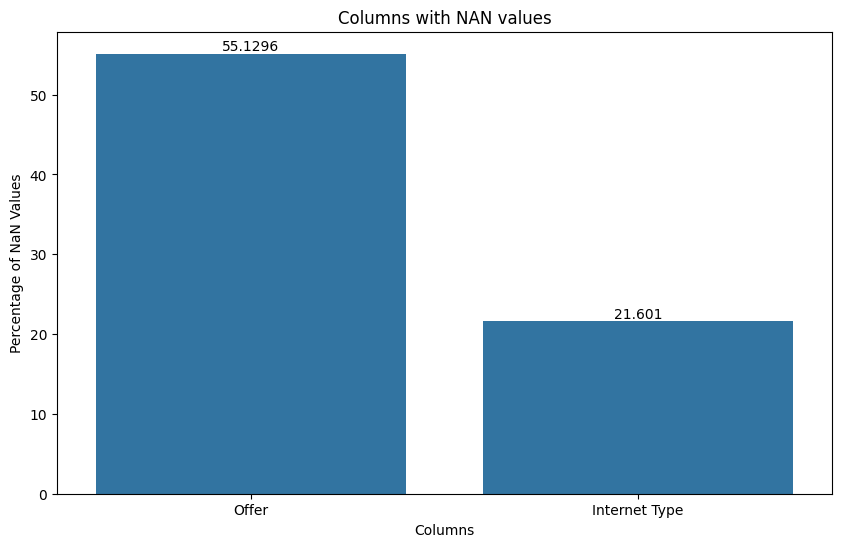

In [24]:
# training set
plot_nans(X_train)

In this notebook, I am using the rational that a Nan in a column has a meaning Therefore I am coing to full the Nan with a value called Nan once they are all categorical

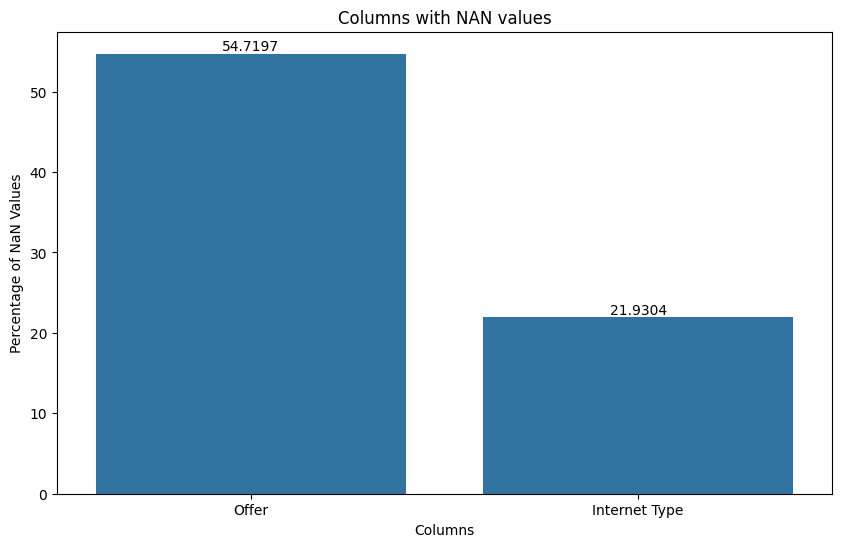

In [25]:
# test set
plot_nans(X_test)

In [26]:
# the test set has the same distribution, therefore we can apply the same solution
X_train['Offer']=X_train['Offer'].fillna('Nan')
X_test['Offer']=X_test['Offer'].fillna('Nan')

X_train['Internet Type']=X_train['Internet Type'].fillna('Nan')
X_test['Internet Type']=X_test['Internet Type'].fillna('Nan')

In [27]:
# now are going to use ordinarEncoding for columns with cardinatity <= 2
# and move that we are going to use OneHotEncoding

feature_series = X_train[features_cat].nunique().sort_values(ascending=False)
feature_series

Offer                     6
Internet Type             4
Payment Method            3
Contract                  3
Online Backup             2
Paperless Billing         2
Unlimited Data            2
Streaming Music           2
Streaming Movies          2
Streaming TV              2
Premium Tech Support      2
Device Protection Plan    2
Gender                    2
Under 30                  2
Internet Service          2
Multiple Lines            2
Phone Service             2
Referred a Friend         2
Dependents                2
Married                   2
Senior Citizen            2
Online Security           2
dtype: int64

In [28]:
# let us get the features to apply oneHotEncoding and OrdinalEncoding
ordinal_features = []
onehot_features = []

for key, value in feature_series.items():
    if value > 2:
        onehot_features.append(key)
    else:
        ordinal_features.append(key)

print('ordinal: ', ordinal_features)
print('onehot: ', onehot_features)

ordinal:  ['Online Backup', 'Paperless Billing', 'Unlimited Data', 'Streaming Music', 'Streaming Movies', 'Streaming TV', 'Premium Tech Support', 'Device Protection Plan', 'Gender', 'Under 30', 'Internet Service', 'Multiple Lines', 'Phone Service', 'Referred a Friend', 'Dependents', 'Married', 'Senior Citizen', 'Online Security']
onehot:  ['Offer', 'Internet Type', 'Payment Method', 'Contract']


In [29]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Initialize the OrdinalEncoder
Ordinal_encoder = OrdinalEncoder()

# Fit and transform the categorical features
train_encoded_array = Ordinal_encoder.fit_transform(X_train[ordinal_features])

# Convert the encoded array to a DataFrame
df_train_encoded = pd.DataFrame(train_encoded_array, columns=ordinal_features)

# Reset index of the original DataFrame
X_train.reset_index(drop=True, inplace=True)

# Join the encoded DataFrame with the original DataFrame
X_train = X_train.join(df_train_encoded, rsuffix='_encoded')

# Drop the original categorical features
X_train.drop(ordinal_features, axis=1, inplace=True)
X_train.head().T

0                1  \
Customer ID                             5402-HTOTQ       7145-FEJWU   
Age                                             43               62   
Number of Dependents                             0                2   
Zip Code                                     96058            94134   
Latitude                                     41.77            37.72   
Longitude                                  -121.92          -122.41   
Population                                     816            40137   
Number of Referrals                              0                0   
Tenure in Months                                16               12   
Offer                                          Nan              Nan   
Avg Monthly Long Distance Charges             5.79            16.96   
Internet Type                                  DSL      Fiber Optic   
Avg Monthly GB Download                          4               18   
Contract                            Month-to-Month   Month-to-Month   
Payment Method                     Bank Withdrawal  Bank Withdrawal   
Monthly Charge                               55.30           105.30   
Total Charges                               875.35         1,275.65   
Total Refunds                                 0.00             0.00   
Total Extra Data Charges                         0                0   
Total Long Distance Charges                  92.64           203.52   
Total Revenue                               967.99         1,479.17   
Satisfaction Score                               5                3   
Churn Score                                     25               72   
CLTV                                          3771             5913   
Online Backup_encoded                         1.00             1.00   
Paperless Billing_encoded                     0.00             1.00   
Unlimited Data_encoded                        1.00             1.00   
Streaming Music_encoded                       0.00             1.00   
Streaming Movies_encoded                      0.00             1.00   
Streaming TV_encoded                          0.00             1.00   
Premium Tech Support_encoded                  0.00             0.00   
Device Protection Plan_encoded                0.00             1.00   
Gender_encoded                                1.00             0.00   
Under 30_encoded                              0.00             0.00   
Internet Service_encoded                      1.00             1.00   
Multiple Lines_encoded                        1.00             1.00   
Phone Service_encoded                         1.00             1.00   
Referred a Friend_encoded                     0.00             0.00   
Dependents_encoded                            0.00             1.00   
Married_encoded                               0.00             0.00   
Senior Citizen_encoded                        0.00             0.00   
Online Security_encoded                       0.00             0.00   

                                                2                3  \
Customer ID                            2607-FBDFF       1474-JUWSM   
Age                                            32               24   
Number of Dependents                            0                0   
Zip Code                                    95379            90262   
Latitude                                    37.94            33.92   
Longitude                                 -120.19          -118.20   
Population                                   3979            69850   
Number of Referrals                             0                8   
Tenure in Months                                1               58   
Offer                                         Nan              Nan   
Avg Monthly Long Distance Charges           49.19            26.99   
Internet Type                                 DSL            Cable   
Avg Monthly GB Download                        17               53   
Contract       

In [30]:
# Transform the categorical features on the test set using the same encoder
test_encoded_array = Ordinal_encoder.transform(X_test[ordinal_features])

# Convert the encoded array to a DataFrame
df_test_encoded = pd.DataFrame(test_encoded_array, columns=ordinal_features)

# Reset index of the original DataFrame
X_test.reset_index(drop=True, inplace=True)

# Join the encoded DataFrame with the original DataFrame
X_test = X_test.join(df_test_encoded, rsuffix='_encoded')

# Drop the original categorical features
X_test.drop(ordinal_features, axis=1, inplace=True)

X_test.head().T


0                1  \
Customer ID                             5019-GQVCR       3766-EJLFL   
Age                                             74               55   
Number of Dependents                             0                3   
Zip Code                                     91361            96061   
Latitude                                     34.13            40.33   
Longitude                                  -118.89          -121.46   
Population                                   18735               78   
Number of Referrals                              0                1   
Tenure in Months                                43               68   
Offer                                          Nan              Nan   
Avg Monthly Long Distance Charges             8.81            18.42   
Internet Type                          Fiber Optic      Fiber Optic   
Avg Monthly GB Download                          7               53   
Contract                                  Two Year         Two Year   
Payment Method                     Bank Withdrawal  Bank Withdrawal   
Monthly Charge                               84.85           109.05   
Total Charges                             3,645.60         7,508.55   
Total Refunds                                 0.00             0.00   
Total Extra Data Charges                         0                0   
Total Long Distance Charges                 378.83         1,252.56   
Total Revenue                             4,024.43         8,761.11   
Satisfaction Score                               4                4   
Churn Score                                     56               80   
CLTV                                          4556             6391   
Online Backup_encoded                         0.00             0.00   
Paperless Billing_encoded                     1.00             1.00   
Unlimited Data_encoded                        1.00             1.00   
Streaming Music_encoded                       0.00             1.00   
Streaming Movies_encoded                      0.00             1.00   
Streaming TV_encoded                          1.00             1.00   
Premium Tech Support_encoded                  0.00             1.00   
Device Protection Plan_encoded                0.00             1.00   
Gender_encoded                                1.00             0.00   
Under 30_encoded                              0.00             0.00   
Internet Service_encoded                      1.00             1.00   
Multiple Lines_encoded                        1.00             1.00   
Phone Service_encoded                         1.00             1.00   
Referred a Friend_encoded                     0.00             1.00   
Dependents_encoded                            0.00             1.00   
Married_encoded                               0.00             1.00   
Senior Citizen_encoded                        1.00             0.00   
Online Security_encoded                       0.00             1.00   

                                                 2            3            4  
Customer ID                             9764-REAFF   6199-IPCAO   2378-YIZKA  
Age                                             60           62           61  
Number of Dependents                             0            2            1  
Zip Code                                     95979        93561        96094  
Latitude                                     39.29        35.07        41.47  
Longitude                                  -122.42      -118.65      -122.38  
Population                                     844        25805         5896  
Number of Referrals                              9            8            7  
Tenure in Months                                59           29           68  
Offer                                      Offer B          Nan          Nan  
Avg Monthly Long Distance Charges            26.99         5.35         6.28  
Internet Type                                  

In [31]:
# now we can apply the onehotencoding to the categories with a cardinality > 2
# Initialize the OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the categorical features on the training set
train_encoded_array = onehot_encoder.fit_transform(X_train[onehot_features])

# Get the new column names for the one-hot encoded features
encoded_columns = onehot_encoder.get_feature_names_out(onehot_features)

# Convert the encoded array to a DataFrame
df_train_encoded = pd.DataFrame(train_encoded_array, columns=encoded_columns)

# Reset index of the original DataFrame
X_train.reset_index(drop=True, inplace=True)

# Join the encoded DataFrame with the original DataFrame
X_train = X_train.join(df_train_encoded)

# Drop the original categorical features
X_train.drop(onehot_features, axis=1, inplace=True)

# Transform the categorical features on the test set using the same encoder
test_encoded_array = onehot_encoder.transform(X_test[onehot_features])

# Convert the encoded array to a DataFrame
df_test_encoded = pd.DataFrame(test_encoded_array, columns=encoded_columns)

# Reset index of the original DataFrame
X_test.reset_index(drop=True, inplace=True)

# Join the encoded DataFrame with the original DataFrame
X_test = X_test.join(df_test_encoded)

# Drop the original categorical features
X_test.drop(onehot_features, axis=1, inplace=True)

In [32]:
# Display the first few rows of the modified training and test sets
X_train.head(2).T

0           1
Customer ID                        5402-HTOTQ  7145-FEJWU
Age                                        43          62
Number of Dependents                        0           2
Zip Code                                96058       94134
Latitude                                41.77       37.72
Longitude                             -121.92     -122.41
Population                                816       40137
Number of Referrals                         0           0
Tenure in Months                           16          12
Avg Monthly Long Distance Charges        5.79       16.96
Avg Monthly GB Download                     4          18
Monthly Charge                          55.30      105.30
Total Charges                          875.35    1,275.65
Total Refunds                            0.00        0.00
Total Extra Data Charges                    0           0
Total Long Distance Charges             92.64      203.52
Total Revenue                          967.99    1,479.17
Satisfaction Score                          5           3
Churn Score                                25          72
CLTV                                     3771        5913
Online Backup_encoded                    1.00        1.00
Paperless Billing_encoded                0.00        1.00
Unlimited Data_encoded                   1.00        1.00
Streaming Music_encoded                  0.00        1.00
Streaming Movies_encoded                 0.00        1.00
Streaming TV_encoded                     0.00        1.00
Premium Tech Support_encoded             0.00        0.00
Device Protection Plan_encoded           0.00        1.00
Gender_encoded                           1.00        0.00
Under 30_encoded                         0.00        0.00
Internet Service_encoded                 1.00        1.00
Multiple Lines_encoded                   1.00        1.00
Phone Service_encoded                    1.00        1.00
Referred a Friend_encoded                0.00        0.00
Dependents_encoded                       0.00        1.00
Married_encoded                          0.00        0.00
Senior Citizen_encoded                   0.00        0.00
Online Security_encoded                  0.00        0.00
Offer_Nan                                1.00        1.00
Offer_Offer A                            0.00        0.00
Offer_Offer B                            0.00        0.00
Offer_Offer C                            0.00        0.00
Offer_Offer D                            0.00        0.00
Offer_Offer E                            0.00        0.00
Internet Type_Cable                      0.00        0.00
Internet Type_DSL                        1.00        0.00
Internet Type_Fiber Optic                0.00        1.00
Internet Type_Nan                        0.00        0.00
Payment Method_Bank Withdrawal           1.00        1.00
Payment Method_Credit Card               0.00        0.00
Payment Method_Mailed Check              0.00        0.00
Contract_Month-to-Month                  1.00        1.00
Contract_One Year                        0.00        0.00
Contract_Two Year                        0.00        0.00

In [33]:
X_test.head(2).T

0           1
Customer ID                        5019-GQVCR  3766-EJLFL
Age                                        74          55
Number of Dependents                        0           3
Zip Code                                91361       96061
Latitude                                34.13       40.33
Longitude                             -118.89     -121.46
Population                              18735          78
Number of Referrals                         0           1
Tenure in Months                           43          68
Avg Monthly Long Distance Charges        8.81       18.42
Avg Monthly GB Download                     7          53
Monthly Charge                          84.85      109.05
Total Charges                        3,645.60    7,508.55
Total Refunds                            0.00        0.00
Total Extra Data Charges                    0           0
Total Long Distance Charges            378.83    1,252.56
Total Revenue                        4,024.43    8,761.11
Satisfaction Score                          4           4
Churn Score                                56          80
CLTV                                     4556        6391
Online Backup_encoded                    0.00        0.00
Paperless Billing_encoded                1.00        1.00
Unlimited Data_encoded                   1.00        1.00
Streaming Music_encoded                  0.00        1.00
Streaming Movies_encoded                 0.00        1.00
Streaming TV_encoded                     1.00        1.00
Premium Tech Support_encoded             0.00        1.00
Device Protection Plan_encoded           0.00        1.00
Gender_encoded                           1.00        0.00
Under 30_encoded                         0.00        0.00
Internet Service_encoded                 1.00        1.00
Multiple Lines_encoded                   1.00        1.00
Phone Service_encoded                    1.00        1.00
Referred a Friend_encoded                0.00        1.00
Dependents_encoded                       0.00        1.00
Married_encoded                          0.00        1.00
Senior Citizen_encoded                   1.00        0.00
Online Security_encoded                  0.00        1.00
Offer_Nan                                1.00        1.00
Offer_Offer A                            0.00        0.00
Offer_Offer B                            0.00        0.00
Offer_Offer C                            0.00        0.00
Offer_Offer D                            0.00        0.00
Offer_Offer E                            0.00        0.00
Internet Type_Cable                      0.00        0.00
Internet Type_DSL                        0.00        0.00
Internet Type_Fiber Optic                1.00        1.00
Internet Type_Nan                        0.00        0.00
Payment Method_Bank Withdrawal           1.00        1.00
Payment Method_Credit Card               0.00        0.00
Payment Method_Mailed Check              0.00        0.00
Contract_Month-to-Month                  0.00        0.00
Contract_One Year                        0.00        0.00
Contract_Two Year                        1.00        1.00

In [34]:
dataFrame_summary(X_train).style.background_gradient(cmap='YlOrBr')

data shape: (5634, 54)


In [35]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame,
                             title_name: str = 'correlation'):
    '''
    Generate graphs with orrelation between numerical variable

    Parameters:
    df (pandas.DataFrame): The DataFrame
    title_name (ste): name of the chart
    '''
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(25, 12))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='RdBu_r',
                annot=True, annot_kws={"size": 8})
    plt.title(title_name)
    plt.show()

In [36]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame,
                             title_name: str = 'correlation'):
    '''
    Generate graphs with orrelation between numerical variable

    Parameters:
    df (pandas.DataFrame): The DataFrame
    title_name (ste): name of the chart
    '''
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(25, 12))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='RdBu_r',
                annot=True, annot_kws={"size": 8})
    plt.title(title_name)
    plt.show()

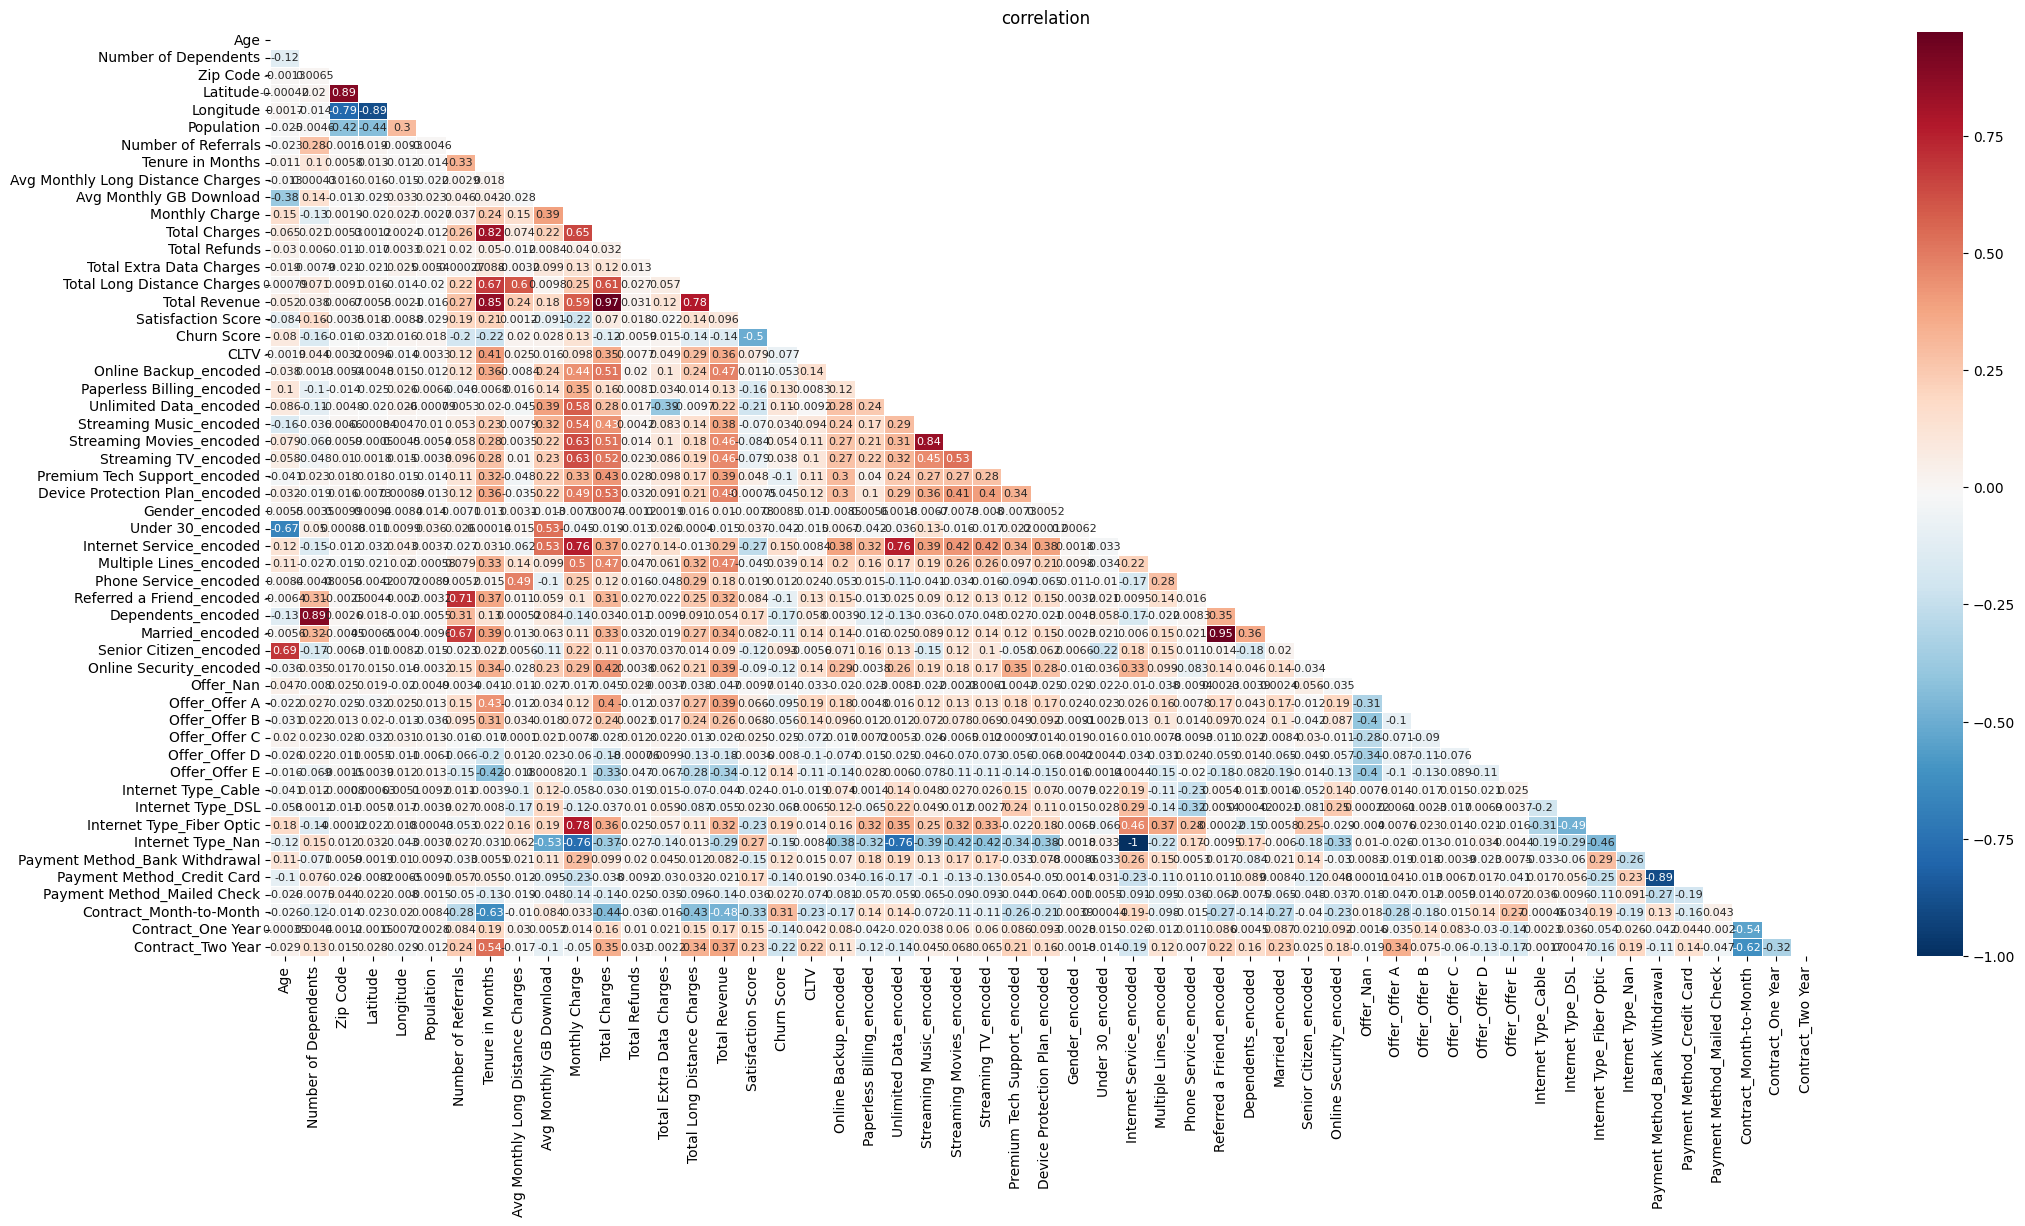

In [37]:
plot_correlation_heatmap(X_train.drop(['Customer ID'], axis=1))

In [38]:
#mapping labels to 1 or 0
label_train = pd.DataFrame(y_train.map({'Yes': 1, 'No': 0}))
label_test = pd.DataFrame(y_test.map({'Yes': 1, 'No': 0}))

**Section 4: Modelling**

Here we are going to use a tree based model

In [39]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold


In [40]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4]
}

# Define evaluation metric
scoring = {'AUC': 'roc_auc', 'F1': 'f1', 'Precision': 'precision',
           'Recall': 'recall'}

In [41]:
# Define the XGBoost model
model = XGBClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring=scoring,
    refit='AUC',
    n_iter=100,  # Number of parameter settings that are sampled
    cv=StratifiedKFold(n_splits=5, shuffle=True),  # Cross-validation strategy
    verbose=3,
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

In [42]:
# Perform RandomizedSearchCV
random_search.fit(X_train.drop(['Customer ID'], axis=1), label_train)

# Get the best parameters and best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

# Print the best parameters
print("Best Parameters:")
print(best_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:
{'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.6}


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1035
           1       0.98      0.97      0.97       374

    accuracy                           0.99      1409
   macro avg       0.98      0.98      0.98      1409
weighted avg       0.99      0.99      0.99      1409

ROC AUC Score: 0.9991242346741067


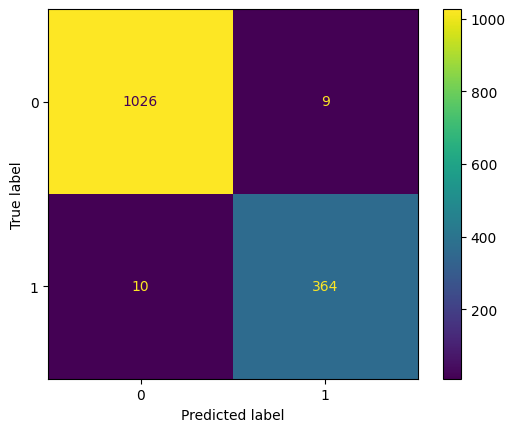

In [43]:
# Evaluate the best model on the test set
y_pred = best_estimator.predict(X_test.drop(['Customer ID'], axis=1))
print("Classification Report:")
print(classification_report(label_test, y_pred))

# Calculate ROC AUC score
y_pred_proba = best_estimator.predict_proba(X_test.drop(['Customer ID'],
                                                        axis=1))[:, 1]
roc_auc = roc_auc_score(label_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

cm = confusion_matrix(label_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4139
           1       1.00      0.99      1.00      1495

    accuracy                           1.00      5634
   macro avg       1.00      1.00      1.00      5634
weighted avg       1.00      1.00      1.00      5634

ROC AUC Score: 0.9999814150575205


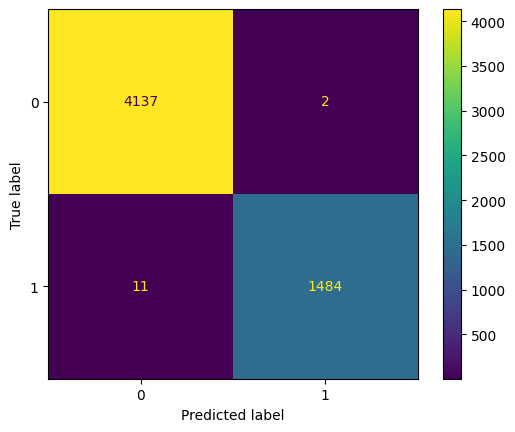

In [44]:
# Evaluate the best model on the test set
y_pred = best_estimator.predict(X_train.drop(['Customer ID'],axis=1))
print("Classification Report:")
print(classification_report(label_train, y_pred))

# Calculate ROC AUC score
y_pred_proba = best_estimator.predict_proba(X_train.drop(['Customer ID'],axis=1))[:, 1]
roc_auc = roc_auc_score(label_train, y_pred_proba)
print("ROC AUC Score:", roc_auc)

cm = confusion_matrix(label_train, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()

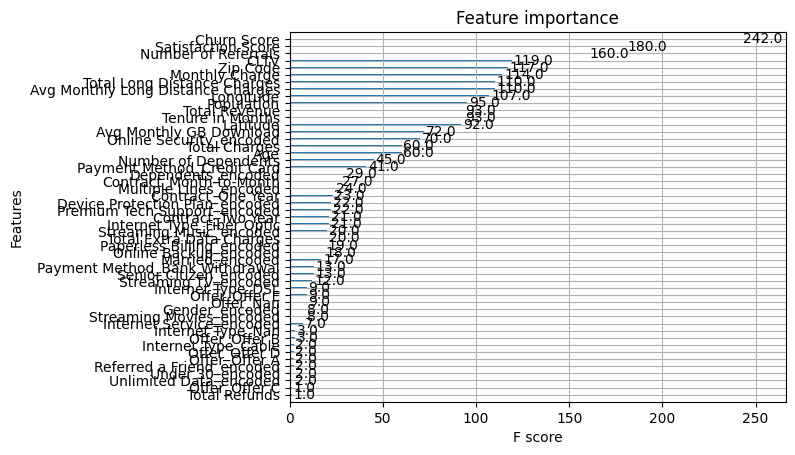

In [45]:
# Import necessary libraries
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(best_estimator)
plt.show()

In [46]:
# Perform RandomizedSearchCV
random_search.fit(X_train.drop(['Customer ID','Churn Score'],axis=1),label_train)

# Get the best parameters and best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

# Print the best parameters
print("Best Parameters:")
print(best_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:
{'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1035
           1       0.97      0.90      0.93       374

    accuracy                           0.97      1409
   macro avg       0.97      0.94      0.95      1409
weighted avg       0.97      0.97      0.96      1409

ROC AUC Score: 0.9923945335710042


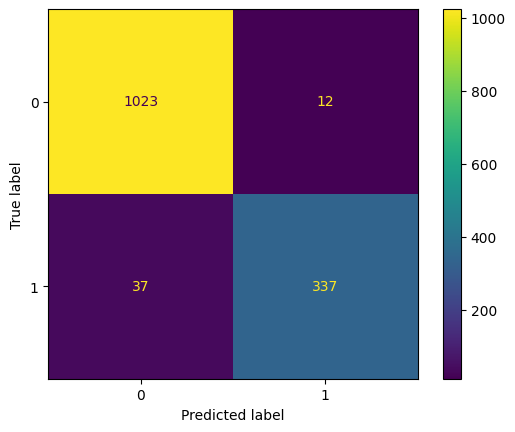

In [47]:
# Evaluate the best model on the test set
y_pred = best_estimator.predict(X_test.drop(['Customer ID','Churn Score'],axis=1))
print("Classification Report:")
print(classification_report(label_test, y_pred))

# Calculate ROC AUC score
y_pred_proba = best_estimator.predict_proba(X_test.drop(['Customer ID','Churn Score'],axis=1))[:, 1]
roc_auc = roc_auc_score(label_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

cm = confusion_matrix(label_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4139
           1       0.99      0.95      0.97      1495

    accuracy                           0.98      5634
   macro avg       0.99      0.97      0.98      5634
weighted avg       0.98      0.98      0.98      5634

ROC AUC Score: 0.998865510467767


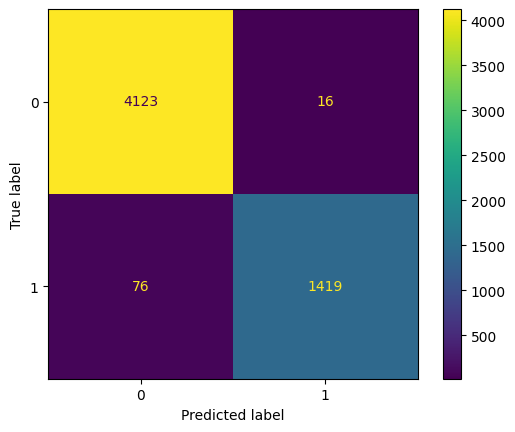

In [48]:
# Evaluate the best model on the test set
y_pred = best_estimator.predict(X_train.drop(['Customer ID','Churn Score'],axis=1))
print("Classification Report:")
print(classification_report(label_train, y_pred))

# Calculate ROC AUC score
y_pred_proba = best_estimator.predict_proba(X_train.drop(['Customer ID','Churn Score'],axis=1))[:, 1]
roc_auc = roc_auc_score(label_train, y_pred_proba)
print("ROC AUC Score:", roc_auc)

cm = confusion_matrix(label_train, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()

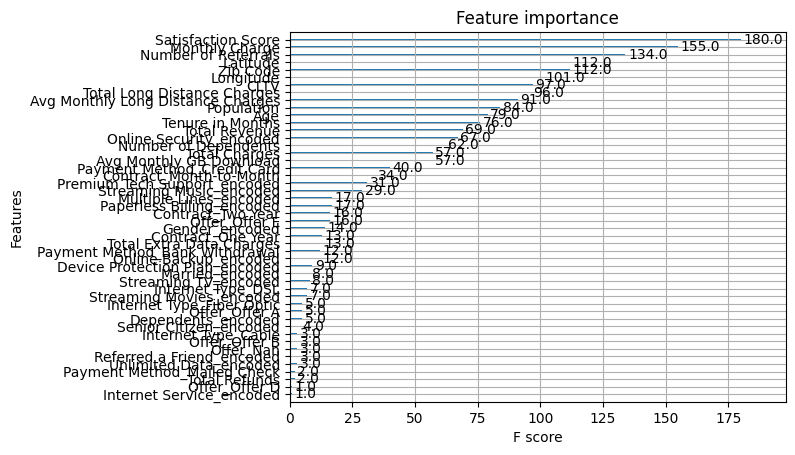

In [49]:
# Import necessary libraries
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(best_estimator) # Use xgb.plot_importance
plt.show()

In [50]:
colors = ['#3A4C6A','#df7a48']
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

In [51]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import shap
shap.initjs()

In [52]:
explainer = shap.TreeExplainer(best_estimator)
shap_values = explainer(X_train.drop(['Customer ID','Churn Score'],axis=1))

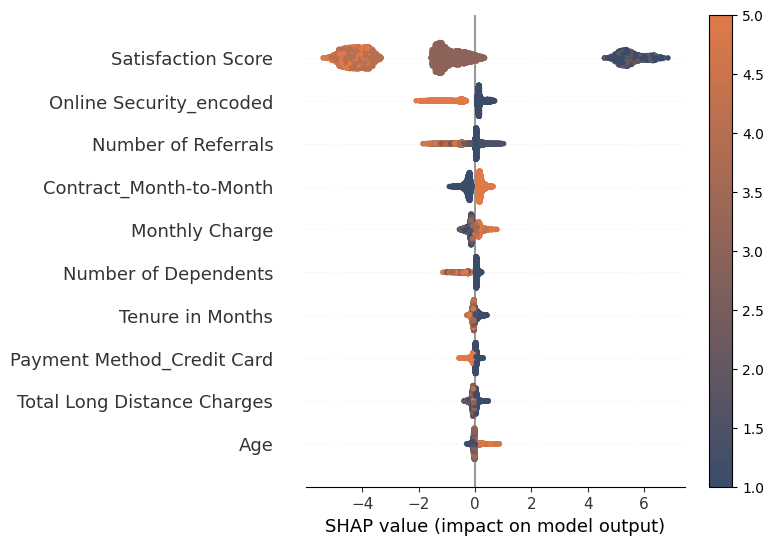

In [53]:
shap.summary_plot(shap_values=shap_values,show=False,color_bar=False, cmap=cmap1,max_display=10)
plt.colorbar()
plt.show()


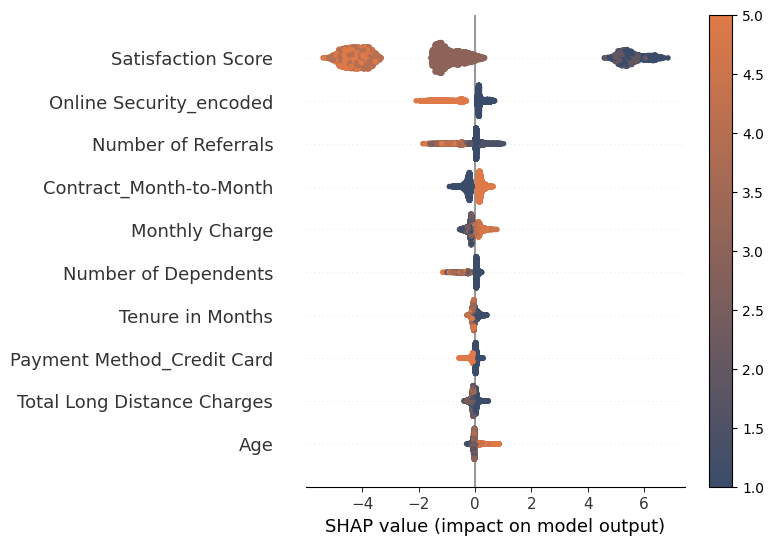

In [54]:
shap.summary_plot(shap_values=shap_values,show=False,color_bar=False, cmap=cmap1,max_display=10)
plt.colorbar()
plt.show()


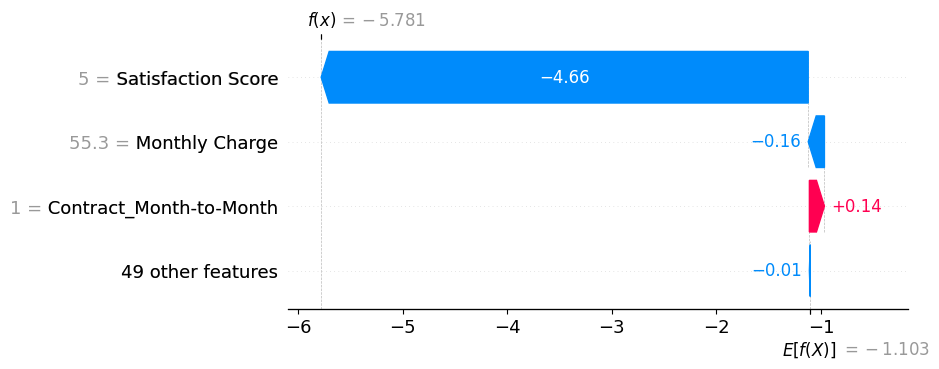

In [55]:
shap.plots.waterfall(shap_values[0], max_display=4)

In [56]:
shap.plots.force(shap_values[0])

**Section 5: Evaluating Results**
Reminder for the Business questions:
1.1. Which services tend to have high churn?
1.2. What would we do to reduce churn?
1.3. What should be the strategy to employ to reduce churn in the future
1.1. Which services tend to have high churn?

From the Data Exploration we could already answer this question

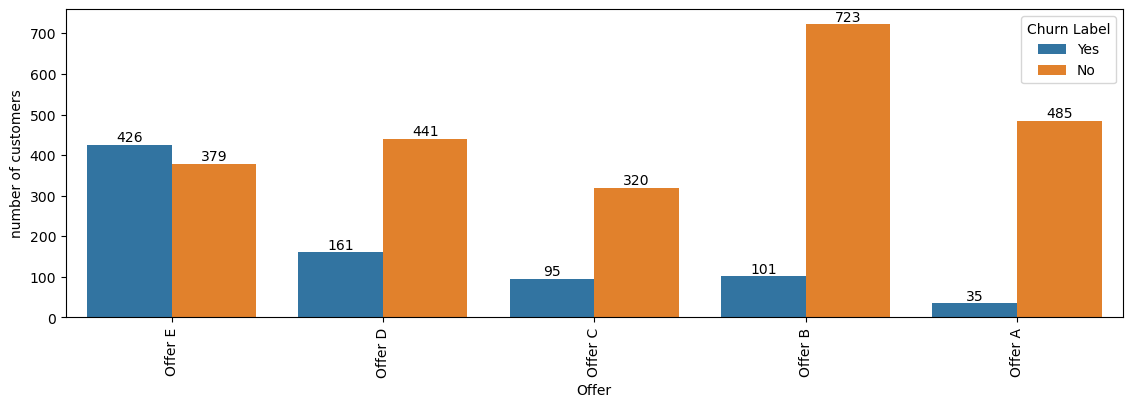

The Commercial department should review the Offers E and D once these have the highest churn rates, here we can move the customers to a different plan for try to address the motives that drive churn in these offering.

**1.2. What would we do to reduce churn?**
From the Data Exploration we see that payment cicly can influence churn, Where the monthly customers churn the most.
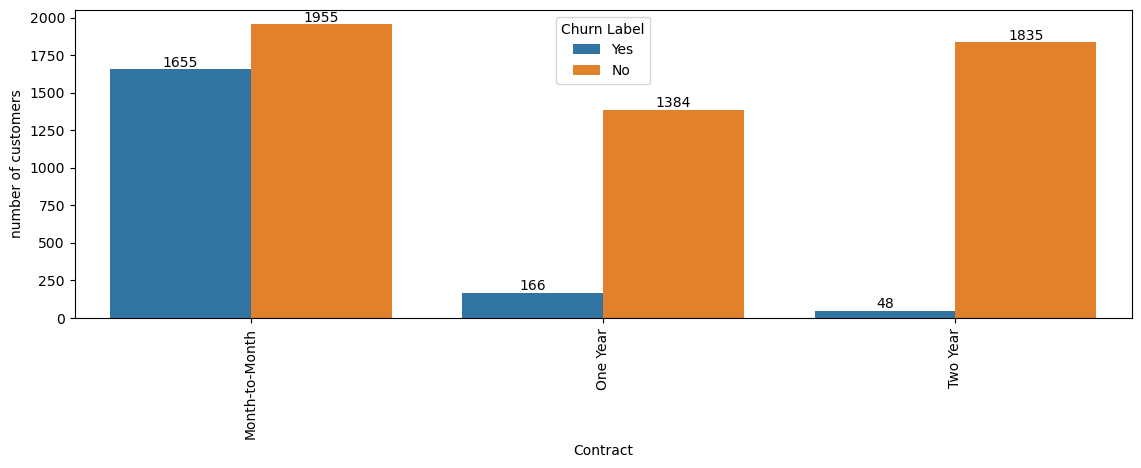

We can see that we need to convert most of our monthly customers to a One-year or Two-year contract once they have lower churn rates. This will help the company get a long term revenue stream and reduce churn.

**1.3. What should be the strategy to employ to reduce churn in the future?**
This can be done by combining the previous finds, the business should:

Address Competition offerings and eliminate Bad offerings with high churn rates, this can mean that the business needs to review the pricing strategy and keep benchmarking against the competition to ensure that they don’t offer better service to the customers.

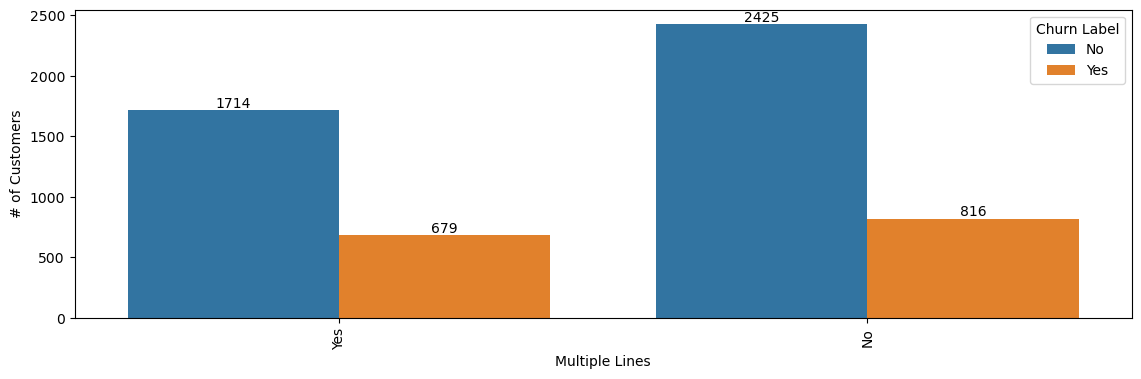

2.Move customers to a payment method that drives stickiness, from monthly payments to a One-year or Two-year plan.

**Kaggle Code**


**Tesco customer churn**

In [57]:
!pip install itables

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.3 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from itables import show
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [59]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [60]:
data = pd.read_csv('/content/drive/MyDrive/telco.csv')

In [61]:
df = data.copy()

In [62]:
columns = [{"orderable": True} for _ in df.columns]

show(df, lengthMenu=[3, 10, 25], search=True , columns=columns, layout= {"top1":"searchBuilder"})

Categorized Age category and make a new column 'Age Distribution

In [63]:
def age_category(age):
    if age < 30:
        return 'Under 30'
    elif age < 64 :
        return 'Working Manpower'
    else:
        return 'Senior Citizen'

In [64]:
df['Age Distribution'] = df['Age'].apply(age_category)

Drop Country column since it has the same value for all entries (i.e., 'United States'). Similarly, drop the States column as all values are 'California'.¶
The Quarter column contains data only for 'Q3', so we can drop it.
Since we have the 'Age Distribution' column, we can also remove the 'Under 30', 'Senior Citizen', and 'Age' columns.

In [65]:
df.drop(columns=['Under 30' , 'Age' , 'Senior Citizen', 'State', 'Country', 'Quarter'], inplace=True)

In [66]:
bins = [0, 12, 24, 36, 48, 60, 72]
labels = [1, 2, 3, 4, 5, 6]

df['Tenure in Years']= pd.cut(df['Tenure in Months'] , bins=bins , labels=labels, right=True).astype('int')

In [67]:
column_to_convert = df.columns[df.isin(['Yes', 'No']).any()]
df[column_to_convert]= df[column_to_convert].replace({'Yes':True , 'No': False})

In [68]:
df_duplicates=df[df.duplicated(df)]

**Age Distribution**

Text(0.5, 1.0, 'Average Revenue by each Age Distribution')

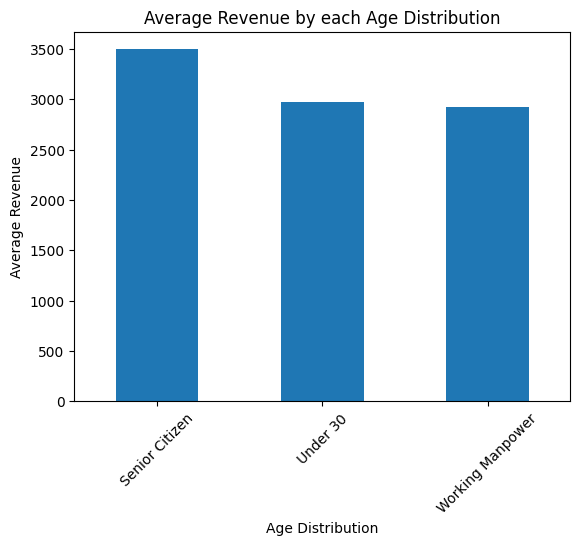

In [69]:
df.groupby('Age Distribution')['Total Revenue'].mean().plot(kind='bar')
plt.ylabel("Average Revenue")
plt.xticks(rotation=45)
plt.title("Average Revenue by each Age Distribution")

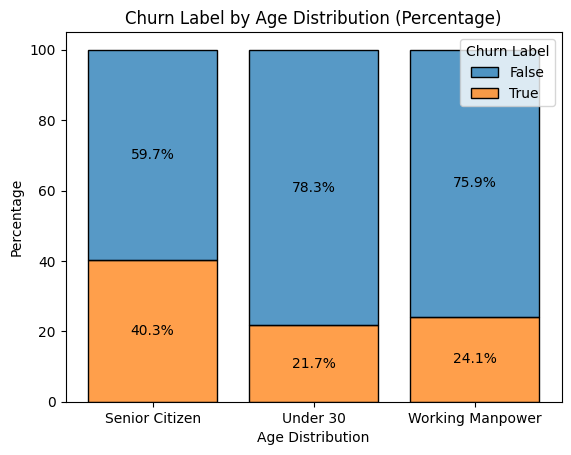

In [70]:
#  Count Churn label for different Age distribution

count_churn = df.groupby(['Age Distribution' , 'Churn Label']).size()

count_churn = df.groupby(['Age Distribution' , 'Churn Label']).size().reset_index(name='Count')


# Count total for each Age Distribution

total_counts = count_churn.groupby('Age Distribution')['Count'].transform('sum')
count_churn['Percentage']= (count_churn['Count']/ total_counts) * 100


ax = sns.histplot(data = count_churn, x='Age Distribution' ,hue='Churn Label' , weights='Percentage',  multiple='stack', shrink=0.8)

for p in ax.patches:
    height = p.get_height()
    x= p.get_x()
    width = p.get_width()
    y = p.get_y()



    ax.annotate(f'{height:.1f}%',
                (x + width / 2, y + height / 2),
                ha='center', va='center',
                xytext=(0, 0),
                textcoords='offset points'
               )

plt.title('Churn Label by Age Distribution (Percentage)')
plt.xlabel('Age Distribution')
plt.ylabel('Percentage')


plt.show()

In [71]:
df[(df['Age Distribution'] == 'Senior Citizen')].groupby('Churn Category')['Churn Reason'].value_counts().sort_values(ascending=False)

Churn Category   Churn Reason                             
Competitor       Competitor made better offer                 96
                 Competitor had better devices                92
Attitude         Attitude of support person                   66
Price            Price too high                               28
Competitor       Competitor offered more data                 28
Attitude         Attitude of service provider                 28
Other            Don't know                                   28
Dissatisfaction  Product dissatisfaction                      23
                 Network reliability                          19
                 Limited range of services                    16
                 Service dissatisfaction                      15
Competitor       Competitor offered higher download speeds    13
Price            Long distance charges                        13
                 Extra data charges                           13
                 Lack of affordable download/upload speed      8
Other            Moved                                         8
                 Poor expertise of online support              7
Dissatisfaction  Poor expertise of online support              3
Other            Deceased                                      2
Dissatisfaction  Poor expertise of phone support               1
                 Lack of self-service on Website               1
Name: count, dtype: int64

The main reason Senior Citizens migrated to a competitor is due to the offers and devices provided by the competitor. Price comes in only the fourth position, after the attitude of the support person.

**Number of Dependents Distribution**

Average revenue by Number of Depedence

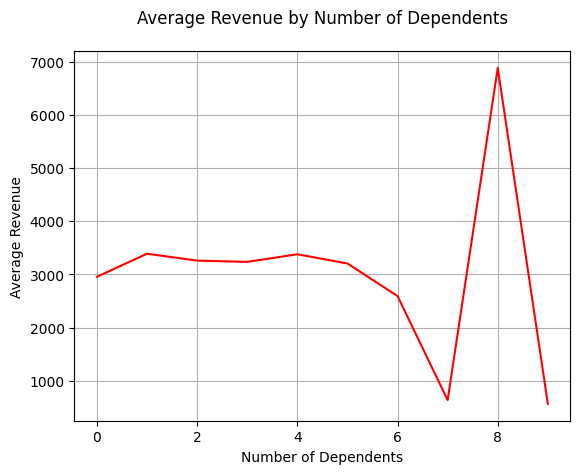

In [72]:
df.groupby('Number of Dependents')['Total Revenue'].mean().plot(kind='line', color='r')
plt.title('Average Revenue by Number of Dependents', pad=20)
plt.xlabel('Number of Dependents')
plt.ylabel('Average Revenue')
plt.grid(True)

In [73]:
df[df['Churn Label'] == True].groupby('Number of Dependents').size().reset_index(name='count')

Number of Dependents  count
0                     0   1763
1                     1     38
2                     2     33
3                     3     30
4                     4      1
5                     5      2
6                     6      1
7                     7      1

Customers with 'Number of Dependents' equal to 0 have the highest churn rate, outnumbering all other groups combined.

Text(0, 0.5, 'Churn Reason')

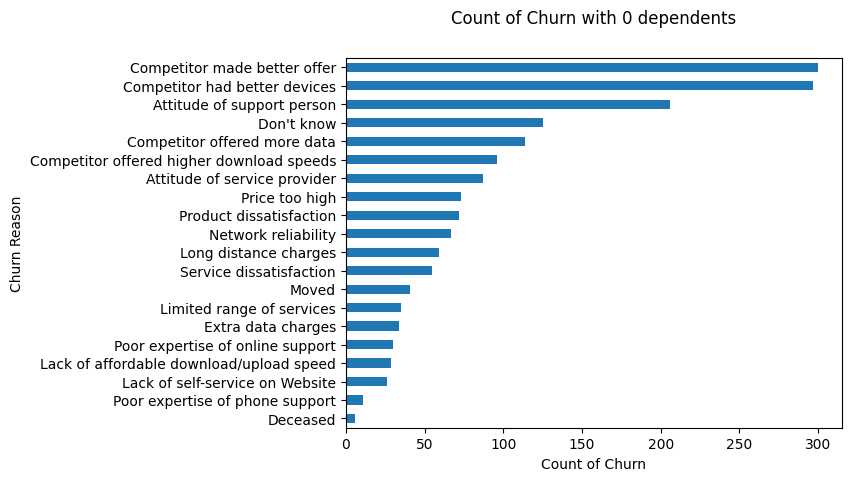

In [74]:
df[df['Number of Dependents'] == 0 ].groupby('Churn Reason').size().sort_values(ascending=True).plot(kind='barh' )
plt.title('Count of Churn with 0 dependents', pad=25)
plt.xlabel('Count of Churn')
plt.ylabel('Churn Reason')

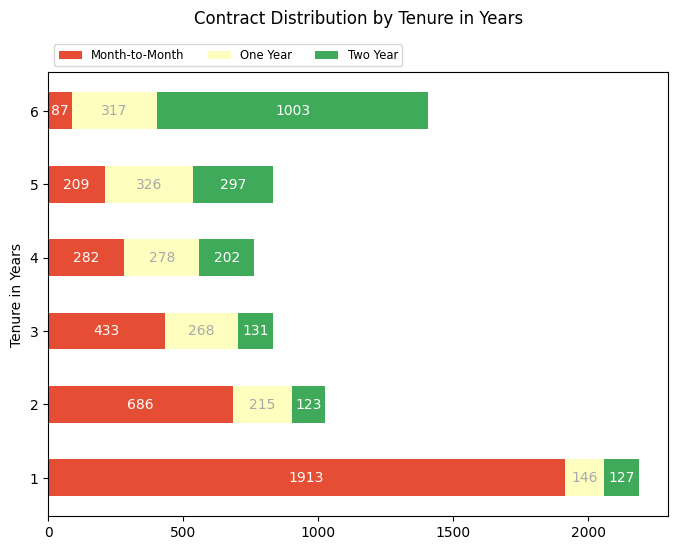

In [76]:
grouped_count = df.groupby('Tenure in Years')['Contract'].value_counts().unstack(fill_value=0)

labels = list(grouped_count.index)
data2 = grouped_count.values
data2_cum = data2.cumsum(axis=1)
category_names = grouped_count.columns.tolist()

category_colors = plt.cm.RdYlGn(np.linspace(0.15, 0.85, data2.shape[1]))

fig, ax = plt.subplots( figsize=(8, 6))

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data2[:, i]
    starts = data2_cum[:, i] - widths
    rects = ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    ax.bar_label(rects, label_type='center', color=text_color)

ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
plt.title('Contract Distribution by Tenure in Years', loc='center', pad=35)
plt.subplots_adjust(top=0.85)

plt.ylabel('Tenure in Years')
plt.show()


In [77]:
internet_group = df.groupby('Churn Label')['Internet Type'].value_counts().unstack()
internet_group

Internet Type  Cable   DSL  Fiber Optic
Churn Label                            
False            617  1345         1799
True             213   307         1236

In [78]:
fig = px.bar(internet_group, barmode='group', height=700, width=1000)
fig.update_layout(title= 'Internet Type Counts by Churn Label',
                  xaxis_title= 'Churn Label',
                  yaxis_title = 'count'
                 )

In [79]:
import plotly.graph_objs as go

def count_occurrences_by_service(df, services):

    # Initialize a dictionary to store the counts for each service
    counts_by_service = {}

    # Iterate over each service column
    for service in services:
        # Filter the DataFrame to include only rows where the current service is True
        service_true_df = df[df[service] == True]

        # Group the filtered DataFrame by 'Churn Label' and count occurrences
        counts_by_churn_label = service_true_df.groupby('Churn Label').size()

        # Store the counts in the dictionary
        counts_by_service[service] = counts_by_churn_label

    return counts_by_service

# Define the services
services = ['Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data']

# Count occurrences for each service
counts_by_service = count_occurrences_by_service(df, services)

# Create traces for each 'Churn Label'
traces = []
for churn_label, counts in counts_by_service.items():
    trace = go.Bar(
        x=list(counts.index),
        y=counts.values,
        name=churn_label
    )
    traces.append(trace)

# Create layout
layout = go.Layout(
    title='Counts of Churn Label for Each Service',
    xaxis=dict(title='Churn Label'),
    yaxis=dict(title='Count')
, width=1000, height=600)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Display the plot
fig.show()


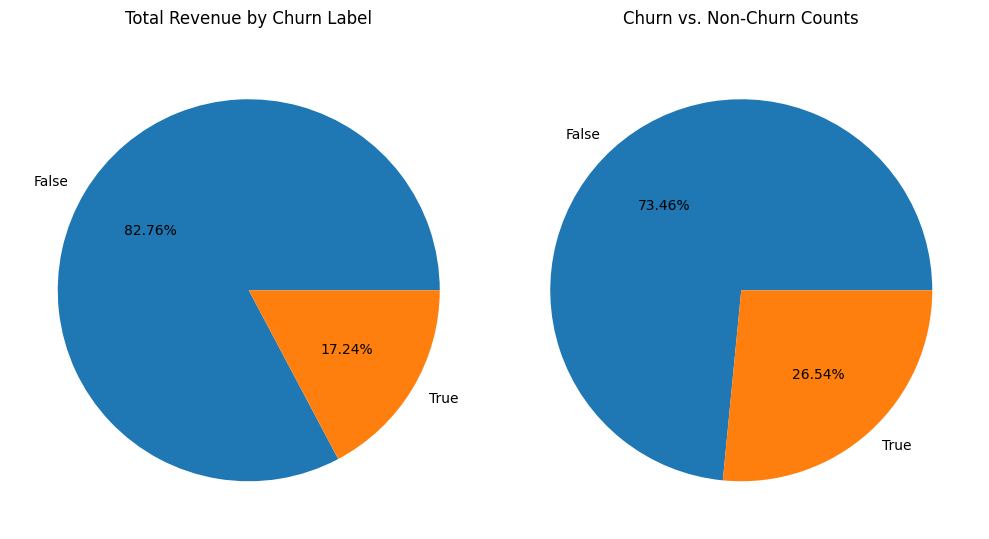

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
df.groupby('Churn Label')['Total Revenue'].sum().plot(kind='pie', autopct='%1.2f%%', ax=ax[0])
ax[0].set_title('Total Revenue by Churn Label', pad = 20)
ax[0].set_ylabel('')

df.groupby('Churn Label').size().plot(kind='pie', autopct='%1.2f%%', ax=ax[1])
ax[1].set_title('Churn vs. Non-Churn Counts', pad = 20)

plt.tight_layout()
plt.show()

**Churn Reasons by Categories**

In [81]:
import plotly.graph_objects as go

# Filter data for churn label True
filtered = df[df['Churn Label'] == True]

# Group by Churn Category and Churn Reason, then calculate counts
filtered_df = filtered.groupby(['Churn Category', 'Churn Reason']).size().reset_index(name='count')

# Group by Churn Category and sum the counts
churn_category_totals = filtered_df.groupby('Churn Category')['count'].sum()

# Get unique churn categories and churn reasons
churn_categories = filtered_df['Churn Category'].unique()
churn_reasons = filtered_df['Churn Reason'].unique()

traces = []

# Set the bar width
bar_width = 0.4

# Iterate over churn categories
for idx, category in enumerate(churn_categories):
    category_data = filtered_df[filtered_df['Churn Category'] == category]
    # Add an offset to the x-coordinate of each bar within the same category
    x_values = [reason for reason in category_data['Churn Reason']]
    offset = idx * bar_width
    traces.append(
        go.Bar(
            x=x_values,
            y=category_data['count'],
            name=category,  # Use Churn Category for legend
            width=bar_width,
            offset=offset,  # Set offset for bars within the same category
            customdata=category_data['count'],  # Store counts as custom data for hover
            hovertemplate="Churn Reason: %{x}<br>Count: %{customdata}",
            visible=True  # Set initial visibility to True
        )
    )

# Create the figure
fig = go.Figure(data=traces)

# Update layout
fig.update_layout(
    xaxis_title='Churn Reason',
    yaxis_title='Count',
    legend_title='Churn Category',
    width=1100,
    height=800
)

# Add toggle buttons for legend items
buttons = []
for category in churn_categories:
    button = dict(
        label=category,
        method='update',
        args=[{'visible': [category in trace.name for trace in fig.data]}]  # Show only traces with selected category
    )
    buttons.append(button)

# Add button to show all categories
buttons.insert(0, dict(label='Show All', method='update', args=[{'visible': [True] * len(fig.data)}]))

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True,
            x=1.05,
            xanchor='left',
            y=0.5,
            yanchor='top'
        )
    ]
)

# Show the plot
fig.show()

Text(0, 0.5, 'Frequency')

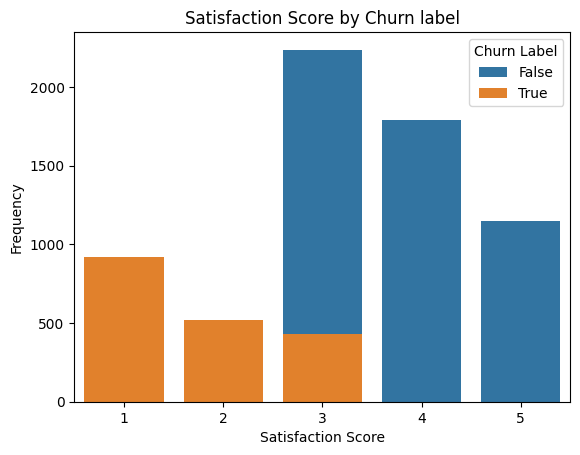

In [82]:
sns.countplot(data=df, x='Satisfaction Score', hue='Churn Label', dodge=False)
plt.title('Satisfaction Score by Churn label')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')

We can see that all clients who gave a '1' or '2' rating have churned.

In [83]:
df[(df['Satisfaction Score'].isin([1, 2])) & (df['Churn Label'] == True) & (df['Churn Reason'] != 'Don\'t know')].groupby('Churn Reason').size().sort_values(ascending=False).reset_index(name='count').head(5)

Churn Reason  count
0              Competitor had better devices    313
1               Competitor made better offer    224
2                 Attitude of support person    150
3               Competitor offered more data     81
4  Competitor offered higher download speeds     79

Text(0, 0.5, 'Total Revenue')

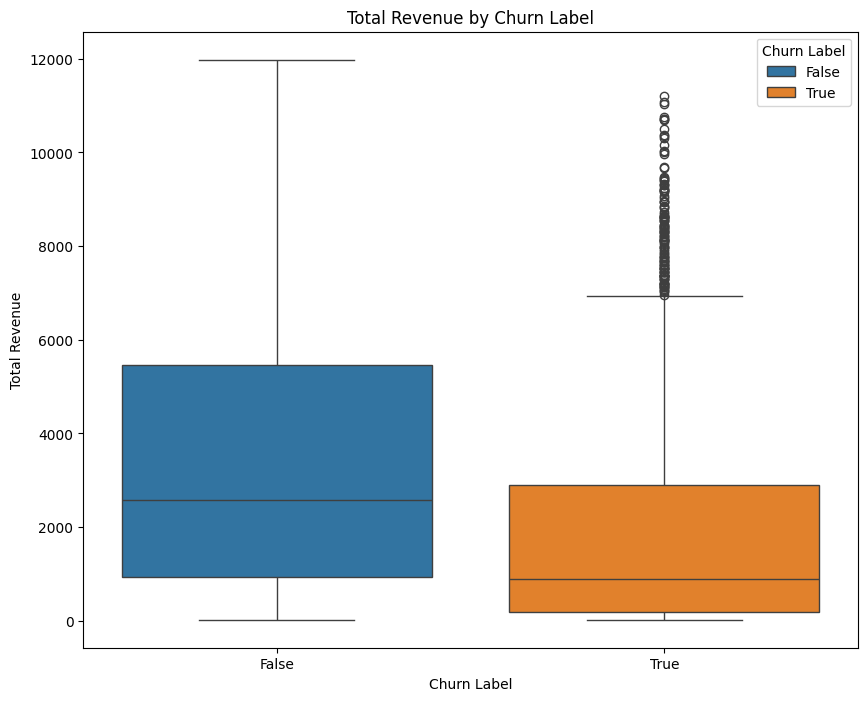

In [84]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='Churn Label', y='Total Revenue', hue='Churn Label')
plt.title('Total Revenue by Churn Label')
plt.xlabel('Churn Label')
plt.ylabel('Total Revenue')

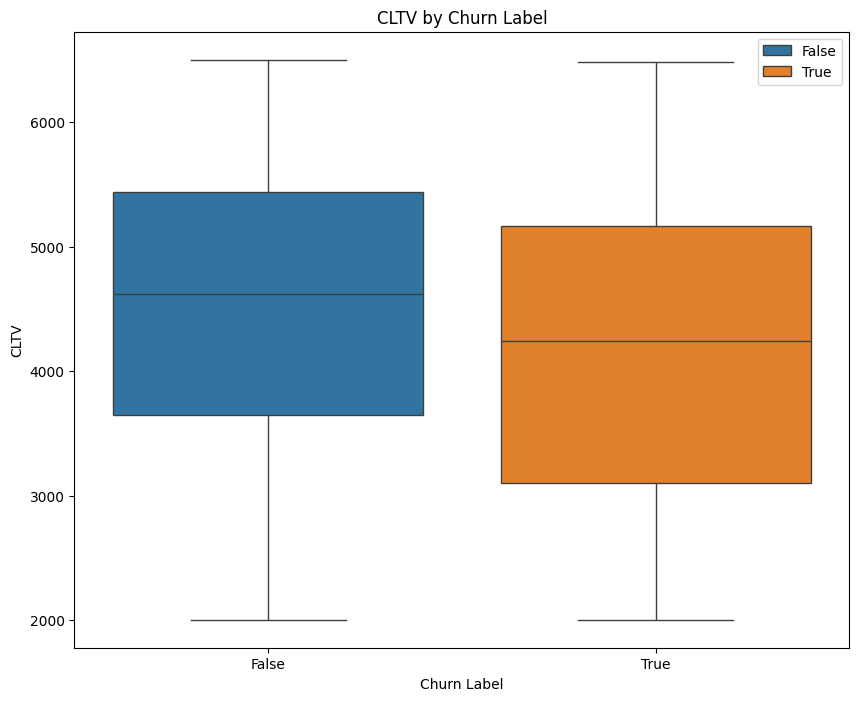

In [85]:
plt.figure(figsize=(10, 8))

sns.boxplot(data = df, x='Churn Label', y='CLTV' , hue='Churn Label')
plt.title('CLTV by Churn Label' )
plt.xlabel('Churn Label')
plt.ylabel('CLTV')
plt.legend(loc='upper right')

The primary revenue source is senior citizens, who largely switch to competitors for better offers and devices, with support staff attitudes ranking third in importance.
Customers with no dependents exhibit the highest churn rate, surpassing all other groups combined. A significant factor contributing to churn includes competition and the demeanor of company support staff.
In the case of internet services, customers with fiber optic connections are more likely to churn.
Among other services, 'Unlimited data' is the most likely to lead to churn, possibly because competitors are offering more data and higher download speeds.
All people who gave a rating of 1 or 2 have churned.
The median total revenue contributed by customers who did not churn is equal to the value at which 75% of the total revenue among churned customers falls below.
In the end of Q3 , 26.54 % client churned , who contributed 17.24 % in total revenue.



*  **Top reasons for churn are**
Competitor had better devices
Competitor made better offer
Attitude of support person





